# Lake mixing and stratification indices

Python notebook created for determine most important indices in stratification and mixing in Pescadero Estuary, CA.

## packages

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.io as sio
from datetime import datetime, timedelta
import gsw
import matplotlib.dates as mdates
import matplotlib.ticker as tick
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
import matplotlib.collections as collections
from numpy.fft import fft, ifft, fftshift, fftfreq
import pywt
from scipy import signal
from scipy.signal import butter, lfilter, freqz
import matplotlib as mpl
from scipy.interpolate import griddata

from sklearn.linear_model import LinearRegression

## useful functions

In [3]:
def to_data(date,da,s,temp):
    x = pd.DataFrame({'Datetime': pd.to_datetime(date, format='%d-%b-%Y %H:%M:%S'), 'Depth': da[:,0], 'Salinity': s[:,0], 'Temperature': temp[:,0]})
    x = x.set_index('Datetime')
    return x  

In [4]:
def to_density(z, sal, temp, lat):
    p = gsw.p_from_z(-z, lat)
    rho = gsw.rho_t_exact(sal, temp, p)
    return rho

In [5]:
def earth_to_uv(dfe, dfn, a): 
    "This takes 2 dataframes of east and north coordinates respectively and the regresion coeficient and transforms them to the direction of the coeficient"
    alpha = np.arctan(a) #Ángulo
    t, b = dfe.shape 
    M = np.array([[-np.cos(alpha), np.sin(alpha)],
                  [np.sin(alpha), np.cos(alpha)]]) #Matriz de transfomación
    columns = dfe.columns
    u = np.zeros((0,t)) #Inicialización de variables
    v = np.zeros((0,t)) #Inicialización de variables
    for i in columns: #Iteración sobre las columnas de los dataframes
        bin_ = np.array([[dfe[i].values],
                        [dfn[i].values]]) # Matriz de coordenadas east-north
        ui, vi = np.tensordot(M, bin_, 1) #Multiplicación matricial
        u = np.concatenate((u, ui), axis=0) #Unión de los resultados de u
        v = np.concatenate((v, vi), axis=0)#Unión de los resultados de v
    return u, v

In [6]:
def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

In [7]:
import math

def haversine(lat1, lon1, lat2, lon2):
    rad = math.pi/180
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    R = 6372.795477598 # km radio de la tierra
    a = (math.sin(rad*dlat/2))**2 + math.cos(rad*lat1)*math.cos(rad*lat2)*(math.sin(rad*dlon/2))**2
    dist = 2*R*math.asin(math.sqrt(a))
    return dist

# Importar y arreglar datos

In [8]:
# feb16 = xr.open_dataset("data/adcp2012feb.nc")
# newfeb = feb16.sel(time=slice("2012-02-17","2012-03-08"))
# adcp = xr.open_dataset("C://Users//Dhannai//Documents//git//dump//adcp//data//adcp2012feb.nc")

UV_burst = xr.open_dataset("data/UV_burst.nc")
EN_burst = xr.open_dataset("data/EastNorth_burst.nc")
vert_burst = pd.read_csv('burst_vert.csv')

In [9]:
# adcp = xr.open_dataset("C://Users//dhann//Documents//git//dump//adcp//data//adcp2012feb.nc")
# adcp = xr.open_dataset("C://Users//Dhannai//Documents//git//dump//adcp//data//adcp2012feb.nc")

In [10]:
DC_CTD = xr.open_dataset("data//DC_CTD")
NM_CTD = xr.open_dataset("data//NM_CTD")
ML_CTD = xr.open_dataset("data//ML_CTD")
PC_CTD = xr.open_dataset("data//PC_CTD")

In [11]:
DC_CTD['v'] = DC_CTD['__xarray_dataarray_variable__']
DC_CTD = DC_CTD.drop(['__xarray_dataarray_variable__'])

NM_CTD['v'] = NM_CTD['__xarray_dataarray_variable__']
NM_CTD = NM_CTD.drop(['__xarray_dataarray_variable__'])

ML_CTD['v'] = ML_CTD['__xarray_dataarray_variable__']
ML_CTD = ML_CTD.drop(['__xarray_dataarray_variable__'])

PC_CTD['v'] = PC_CTD['__xarray_dataarray_variable__']
PC_CTD = PC_CTD.drop(['__xarray_dataarray_variable__'])

In [12]:
z_dc1 = DC_CTD.sel(variables='Depth', sensor=1) - DC_CTD.sel(variables='Depth', sensor=1)
z_dc2 = DC_CTD.sel(variables='Depth', sensor=1) - DC_CTD.sel(variables='Depth', sensor=2)
z_dc2.coords['sensor'] = 2
z_dc3 = DC_CTD.sel(variables='Depth', sensor=1) - DC_CTD.sel(variables='Depth', sensor=3)
z_dc3.coords['sensor'] = 3
z_dc4 = DC_CTD.sel(variables='Depth', sensor=1) - DC_CTD.sel(variables='Depth', sensor=4)
z_dc4.coords['sensor'] = 4
z_dc = xr.concat([z_dc1, z_dc2, z_dc3, z_dc4], "sensor")
z_dc = z_dc.assign_coords(variables=("Depth2"))
DC_CTD = xr.concat([DC_CTD, z_dc], dim="variables")

In [13]:
z_nm1 = DC_CTD.sel(variables='Depth', sensor=1) - NM_CTD.sel(variables='Depth', sensor=1)
z_nm2 = DC_CTD.sel(variables='Depth', sensor=1) - NM_CTD.sel(variables='Depth', sensor=2)
z_nm2.coords['sensor'] = 2
z_nm3 = DC_CTD.sel(variables='Depth', sensor=1) - NM_CTD.sel(variables='Depth', sensor=3)
z_nm3.coords['sensor'] = 3
z_nm = xr.concat([z_nm1, z_nm2, z_nm3], "sensor")
z_nm = z_nm.assign_coords(variables=("Depth2"))
NM_CTD = xr.concat([NM_CTD, z_nm], dim="variables")

In [14]:
z_ml1 = DC_CTD.sel(variables='Depth', sensor=1) - ML_CTD.sel(variables='Depth', sensor=1)
z_ml2 = DC_CTD.sel(variables='Depth', sensor=1) - ML_CTD.sel(variables='Depth', sensor=2)
z_ml2.coords['sensor'] = 2
z_ml = xr.concat([z_ml1, z_ml2], "sensor")
z_ml = z_ml.assign_coords(variables=("Depth2"))
ML_CTD = xr.concat([ML_CTD, z_ml], dim="variables")

In [15]:
z_pc1 = DC_CTD.sel(variables='Depth', sensor=1) - PC_CTD.sel(variables='Depth', sensor=1)
z_pc = xr.concat([z_pc1], "sensor")
z_pc = z_pc.assign_coords(variables=("Depth2"))
PC_CTD = xr.concat([PC_CTD, z_pc], dim="variables")

In [16]:
#Convertir velocidades a DataFrames
columnas = ['bin_1','bin_2','bin_3','bin_4','bin_5','bin_6','bin_7','bin_8','bin_9','bin_10','bin_11','bin_12','bin_13','bin_14','bin_15','bin_16','bin_17','bin_18','bin_19','bin_20','bin_21','bin_22','bin_23','bin_24','bin_25']

df_east = pd.DataFrame(EN_burst.east.values, columns = columnas)
df_east.index = EN_burst.time.values

df_north = pd.DataFrame(EN_burst.north.values, columns = columnas)
df_north.index = EN_burst.time.values

u, v = earth_to_uv(df_east, df_north, 1.13493621)

df_u = pd.DataFrame(np.transpose(u), columns = columnas)
df_u.index = EN_burst.time.values

df_v = pd.DataFrame(np.transpose(v), columns = columnas)
df_v.index = EN_burst.time.values

vert_burst.index = pd.to_datetime(vert_burst['Unnamed: 0'], format='%Y-%m-%d %H:%M:%S')
vert_burst = vert_burst.drop(['Unnamed: 0'], axis=1)

In [17]:
#Viento
df2 = pd.read_table('C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//meteorological_station//raw//CR200Series_sixmin_pescadero_20120301.dat', sep=",", header=[1, 2, 3])
df2 = pd.DataFrame(df2.values, columns = ['TIMESTAMP','RECORD','Speed','Direction','Winddir_D2','airTC','RH'])
df2 = df2.set_index('TIMESTAMP')
df3 = pd.read_table('C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//meteorological_station//raw//CR200Series_sixmin_pescadero_20120419.dat', sep=",", header=[1, 2, 3])
df3 = pd.DataFrame(df3.values, columns = ['TIMESTAMP','RECORD','Speed','Direction','Winddir_D2','airTC','RH'])
df3 = df3.set_index('TIMESTAMP')
result = pd.concat([df2, df3], ignore_index=False, sort=False)
result.index = pd.to_datetime(result.index)
w = result

In [18]:
north_w = np.float64(w['Speed'])*np.sin(np.pi*np.float64(w['Direction'])/180)
east_w = np.float64(w['Speed'])*np.cos(np.pi*np.float64(w['Direction'])/180)
north_w = pd.DataFrame(data=north_w, columns=['viento'])
east_w = pd.DataFrame(data=east_w, columns=['viento'])

uw, vw = earth_to_uv(east_w, north_w, 0.79970532)

dfw = pd.DataFrame(np.transpose(np.array([uw[0,:], vw[0,:]])), columns=['u', 'v'])
dfw.index = w.index

In [19]:
#Leer datos caudal
Q = pd.read_csv("data\\febmar2012.csv")
lista_nombres= ["nan1", "fecha", "nan2", "sensor", 
                "caudal", "A"]
Q.columns=lista_nombres
Q = Q.drop(columns=['nan1', 'nan2', 'sensor', 'A']).reset_index()
Q = Q.drop(columns=['level_0', 'level_1'])
Q["fecha"] = pd.to_datetime(Q["fecha"].values)

In [20]:
#Importar caudal de pescadero cada 15 min en GMT
# https://nwis.waterservices.usgs.gov/nwis/iv/?sites=11162500&parameterCd=00060&startDT=2011-07-07T00:00:00.000-07:00&endDT=2012-07-07T23:59:59.999-07:00&siteStatus=all&format=rdb
Q = pd.read_csv("data\\caudal2012.csv", sep=';')
Q = Q.drop(['5s', '15s', '14n', 'Unnamed: 6'], axis=1)
Q['index'] = pd.to_datetime(Q['20d'] + ' ' + Q['6s'], format='%d-%m-%Y %H:%M')
Q = Q.set_index('index')
Q = Q.drop(['20d', '6s'], axis=1)

In [21]:
#Importar nivel de agua cada 6 min en hora local
snfco = pd.read_csv("data/CO-OPS_9414290_met.csv")
snfco = snfco.drop(['Predicted (m)', 'Preliminary (m)'], axis=1)
snfco['index'] = pd.to_datetime(snfco['Date'] + ' ' + snfco['Time (LST/LDT)'], format='%Y-%m-%d %H:%M')
snfco = snfco.set_index('index')
snfco = snfco.drop(['Date', 'Time (LST/LDT)'], axis=1)

mnty = pd.read_csv("data/CO-OPS_9413450_met.csv")
mnty = mnty.drop(['Predicted (m)', 'Preliminary (m)'], axis=1)
mnty['index'] = pd.to_datetime(mnty['Date'] + ' ' + mnty['Time (LST/LDT)'], format='%Y-%m-%d %H:%M')
mnty = mnty.set_index('index')
mnty = mnty.drop(['Date', 'Time (LST/LDT)'], axis=1)

In [22]:
#Importar datos boya 46012 (Half moon bay)
# https://www.ndbc.noaa.gov/station_history.php?station=46012
hmoon = pd.read_csv("data/46012h2012.csv", sep=';', header=0)
hmoon = hmoon.drop(['PRES','TIDE', 'ATMP', 'WTMP','DEWP', 'VIS', 'WDI', 'R WSP', 'D GST'], axis=1)
hmoon = hmoon.drop([0], axis=0)
hmoon['index'] = pd.to_datetime(hmoon['#YY'] + '-' + hmoon['MM'] + '-' + hmoon['DD'] + ' ' + hmoon['hh'] + ':' + hmoon['mm'], format='%Y-%m-%d %H:%M')
hmoon = hmoon.set_index('index')
hmoon = hmoon.drop(['#YY', 'MM', 'DD', 'hh', 'mm'], axis=1)
hmoon['WVHT'] = hmoon['WVHT'].astype('float64')
hmoon['DPD'] = hmoon['DPD'].astype('float64')
hmoon['APD'] = hmoon['APD'].astype('float64')
hmoon['MWD'] = hmoon['MWD'].astype('float64')
hmoon = hmoon.drop([datetime(2012,2,14,19,50,0), datetime(2012,2,22,11,50,0), datetime(2012,2,23,11,50,0)], axis=0)
# WVHT: Significant wave height
# DPD: Dominant wave period (seconds) is the period with the maximum wave energy.
# APD: Average wave period (seconds) of all waves during the 20-minute period. 

In [23]:
rho_air = 1.2 #densidad del aire
cd = 0.0012 #coeficiente de arrastre obtenido de cousins
k = 0.4 # Coeficiente de von karman
z = 2

## Corrección de velocidad desde 2 a 10 metros 
U = dfw*(1-((cd**0.5)/k) * np.log(10/z))**(-1)

tauw = rho_air*cd*U*abs(U)

## Todo el periodo

In [34]:
bu2 = UV_burst.sel(time=slice("2012-02-11 00:00:00","2012-03-03 00:00:00")).u
wdf = tauw['u'].loc[datetime(2012,2,11):datetime(2012,3,3)]
wdv = tauw['v'].loc[datetime(2012,2,11):datetime(2012,3,3)]
sf = snfco.loc[datetime(2012,2,11):datetime(2012,3,3)]
hm = hmoon.loc[datetime(2012,2,11):datetime(2012,3,3)]
mt = mnty.loc[datetime(2012,2,11):datetime(2012,3,3)]
q = Q.loc[datetime(2012,2,11):datetime(2012,3,3)]

dc = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-03-03 00:00:00")).v
nm = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-03-03 00:00:00")).v
ml = ML_CTD.sel(time=slice("2012-02-11 00:00:00","2012-03-03 00:00:00")).v
pc = PC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-03-03 00:00:00")).v

y_bin = np.linspace(1.19, 3.59, 25)

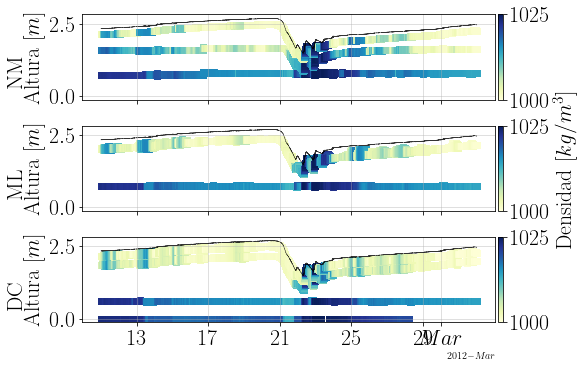

In [25]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax4, ax5, ax3) = plt.subplots(nrows=3, figsize=(8, 5), constrained_layout=True, sharex=True, sharey=True)


#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax3.set_ylabel(r"DC \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax3.plot(dc.time, dc.sel(variables='Depth', sensor=1), c='k', alpha=0.8, linewidth=0.5)
scat = ax3.scatter(dc.time, dc.sel(variables='Depth2', sensor=1), c=dc.sel(variables='Density', sensor=1), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc.time, dc.sel(variables='Depth2', sensor=2), c=dc.sel(variables='Density', sensor=2), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc.time, dc.sel(variables='Depth2', sensor=3), c=dc.sel(variables='Density', sensor=3), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc.time, dc.sel(variables='Depth2', sensor=4), c=dc.sel(variables='Density', sensor=4), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.007)
cbar2.ax.tick_params(labelsize=22)
# cbar2.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)
ax4.set_ylabel(r"NM \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax4.plot(dc.time, dc.sel(variables='Depth', sensor=1), c='k', alpha=0.8, linewidth=0.5)
scat = ax4.scatter(nm.time, nm.sel(variables='Depth2', sensor=1), c=nm.sel(variables='Density', sensor=1), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm.time, nm.sel(variables='Depth2', sensor=2), c=nm.sel(variables='Density', sensor=2), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm.time, nm.sel(variables='Depth2', sensor=3), c=nm.sel(variables='Density', sensor=3), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.007)
cbar3.ax.tick_params(labelsize=22)
# cbar3.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"ML \\ Altura $[m]$",
          fontsize=22)
ax5.plot(dc.time, dc.sel(variables='Depth', sensor=1), c='k', alpha=0.8, linewidth=0.5)
scat = ax5.scatter(ml.time, ml.sel(variables='Depth2', sensor=1), c=ml.sel(variables='Density', sensor=1), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax5.scatter(ml.time, ml.sel(variables='Depth2', sensor=2), c=ml.sel(variables='Density', sensor=2), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.007)
cbar4.ax.tick_params(labelsize=22)
cbar4.set_label("Densidad [$kg/m^3$]", loc='center',
          fontsize=22)
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)


#Ajustar limites colorbar
umin = -0.04
umax = 0.04
vmin = -0.04
vmax = 0.04
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

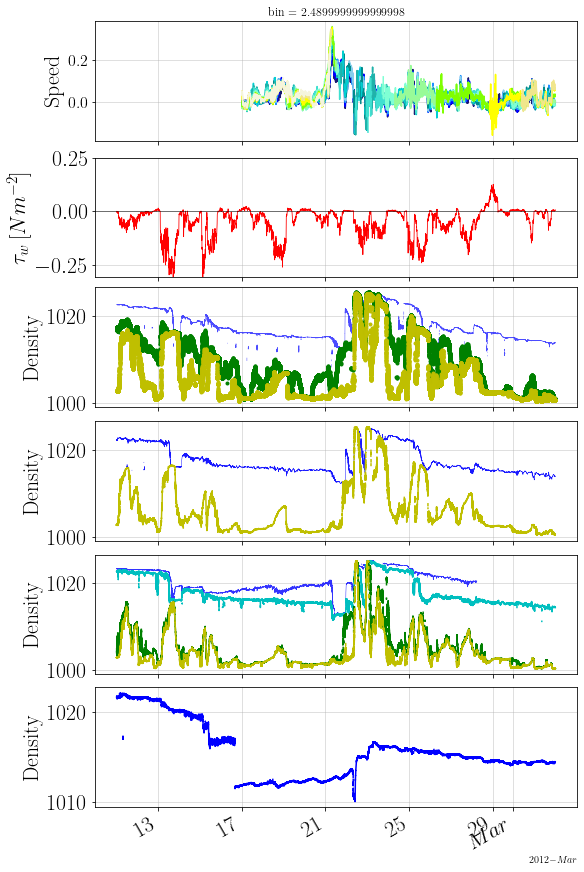

In [26]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6) = plt.subplots(nrows=6, figsize=(8, 12), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)

#Grafico de velocidad del agua 

ax1.set_title("")
bu2.isel(bin=0).plot(ax=ax1, c='midnightblue')
bu2.isel(bin=1).plot(ax=ax1, c='blue')
bu2.isel(bin=2).plot(ax=ax1, c='dodgerblue')
bu2.isel(bin=3).plot(ax=ax1, c='skyblue')
bu2.isel(bin=4).plot(ax=ax1, c='darkcyan')
bu2.isel(bin=5).plot(ax=ax1, c='darkturquoise')
bu2.isel(bin=6).plot(ax=ax1, c='lightseagreen')
bu2.isel(bin=7).plot(ax=ax1, c='turquoise')
bu2.isel(bin=8).plot(ax=ax1, c='aquamarine')
bu2.isel(bin=9).plot(ax=ax1, c='palegreen')
bu2.isel(bin=10).plot(ax=ax1, c='chartreuse')
bu2.isel(bin=11).plot(ax=ax1, c='yellow')
bu2.isel(bin=12).plot(ax=ax1, c='khaki')
bu2.isel(bin=13).plot(ax=ax1, c='beige')



ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_ylabel("Speed", fontsize=22)
ax1.set_xlabel("")



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax3.set_ylabel(r"DC \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax3.plot(dc.time, dc.sel(variables='Density', sensor=1), c='b', alpha=0.8, linewidth=0.5)

dc.sel(variables='Density', sensor=2).plot(ax=ax3, c='c')
dc.sel(variables='Density', sensor=3).plot(ax=ax3, c='g')
dc.sel(variables='Density', sensor=4).plot(ax=ax3, c='y')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.set_title("")
ax3.set_ylabel("Density")
ax3.set_xlabel("")

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)
ax4.set_ylabel(r"NM \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax4.plot(nm.time, nm.sel(variables='Density', sensor=1), c='b', alpha=0.7, linewidth=0.5)
nm.sel(variables='Density', sensor=2).plot(ax=ax4, c='g', marker='.')
nm.sel(variables='Density', sensor=3).plot(ax=ax4, c='y', marker='.')
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.set_title("")
ax4.set_ylabel("Density")
ax4.set_xlabel("")

#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$\tau_w\,[Nm^{-2}]$ ",
          fontsize=22)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.31, 0.25)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"ML \\ Altura $[m]$",
          fontsize=22)
ax5.plot(ml.time, ml.sel(variables='Density', sensor=1), c='b', alpha=0.9, linewidth=0.5)
ml.sel(variables='Density', sensor=2).plot(ax=ax5, c='y')
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)
ax5.set_title("")
ax5.set_ylabel("Density")
ax5.set_xlabel("")

# Grafico densidades PC
pc.sel(variables='Density', sensor=1).plot(ax=ax6, c='b')
ax6.xaxis.set_tick_params(labelsize=22)
ax6.yaxis.set_tick_params(labelsize=22)
ax6.grid(alpha=0.5)
ax6.set_title("")
ax6.set_ylabel("Density", fontsize=22)
ax6.set_xlabel("")

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

## Weddenburn number

### My method:
W: For rectangular basins but can be aproximated (Shintani 2010)
\begin{equation}
W = \frac{g'*h_1^2}{L*u_*^2}
\end{equation}

$h_1$: 30%-70% of DC's total depth (my estimation)

$g'$: reduced gravity (Shintani 2010)

\begin{equation}
g' = \frac{\rho_{bottom} - \rho_{surface}}{\rho_{surface}}*g
\end{equation}

$u_*$: Kinematic shear stress (read 2011)

\begin{equation}
u_*^2 = \frac{\tau_{w}}{\rho_{surface}}
\end{equation}

$\tau_w$ (read 2011): 

\begin{equation}
\tau_w = \rho_{air}*C_D*U_{10}^2
\end{equation}

$U_{10}$: Adjusted from 2 m to 10 m high (read 2011)

\begin{equation}
U_{10} = U_z*\left(1-\frac{C_D^{0.5}}{\kappa}*ln\left(\frac{10}{z}\right)\right)^{-1}
\end{equation}

#### DC

In [30]:
min6_6 = pd.date_range(start=datetime(2012,2,11), end=datetime(2012,3,3), periods=None, freq='6min')

# rho_water = dc.sel(variables='Density').mean('sensor') #se utiliza en u* el promedio de la densidad en todos los sensores
rho_water =  (dc.sel(variables='Density', sensor=4) + dc.sel(variables='Density', sensor=4))/2 #Se utiliza en u* el valor promedio de la capa superficial

g_red = (dc.sel(variables='Density', sensor=1)-dc.sel(variables='Density', sensor=4))*9.81/dc.sel(variables='Density', sensor=4)
rho_air = 1.2

Cd = 0.0014 #Tundisi2002
L = 392 #Obtenido de Google Earth

h1u = 0.3*dc.sel(variables='Depth', sensor=1) # 30% of total depth
h1d = 0.7*dc.sel(variables='Depth', sensor=1) # 70% of total depth
h1c = 0.5*dc.sel(variables='Depth', sensor=1) # 50% of total depth
u_ast2 = (wdf.rename_axis("time").to_xarray()/rho_water.sel(time=min6_6))

Wu = (g_red*h1u**2)/(L*abs(u_ast2))
Wd = (g_red*h1d**2)/(L*abs(u_ast2))
Wc = (g_red*h1c**2)/(L*abs(u_ast2))

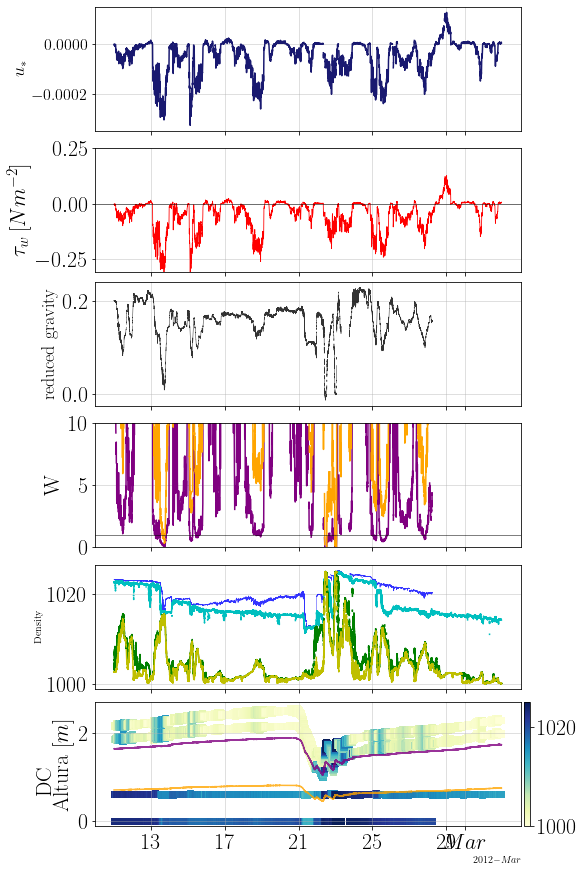

In [31]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6) = plt.subplots(nrows=6, figsize=(8, 12), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)

#Grafico de velocidad del agua 

ax1.set_title("")

ax1.plot(u_ast2.time, u_ast2.values, c='midnightblue')
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_ylabel("$u_*$", fontsize=18)
ax1.set_xlabel("")



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)

ax3.plot(dc.time, dc.sel(variables='Density', sensor=1), c='b', alpha=0.8, linewidth=0.5)

dc.sel(variables='Density', sensor=2).plot(ax=ax3, c='c')
dc.sel(variables='Density', sensor=3).plot(ax=ax3, c='g')
dc.sel(variables='Density', sensor=4).plot(ax=ax3, c='y')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.set_title("")
ax3.set_ylabel("Density")
ax3.set_xlabel("")

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)

ax4.plot(g_red.time, g_red, c='k', alpha=0.8, linewidth=0.5)

ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.set_title("")
ax4.set_xlabel("")
ax4.set_ylabel(r"reduced gravity ",
          fontsize=18)
#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$\tau_w\,[Nm^{-2}]$ ",
          fontsize=22)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.31, 0.25)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"W",
          fontsize=22)
ax5.plot(Wu.time, Wu.values, c="purple")
ax5.plot(Wd.time, Wd.values, c="orange")
# ax5.semilogy(Wu.time, Wu.values, c="purple")
# ax5.semilogy(Wd.time, Wd.values, c="orange")
ax5.axhline(y=1, color='k', linewidth=0.5)
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)
ax5.set_title("")
ax5.set_ylabel("W")
ax5.set_xlabel("")
ax5.set_ylim(0, 10)
ax5.grid(alpha=0.5)
# Grafico densidades DC
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax6.set_ylabel(r"DC \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax6.plot(dc.time, 0.7*dc.sel(variables='Depth', sensor=1), c='purple', alpha=0.8)
ax6.plot(dc.time, 0.3*dc.sel(variables='Depth', sensor=1), c='orange', alpha=0.8)
scat = ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=1), c=dc.sel(variables='Density', sensor=1), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=2), c=dc.sel(variables='Density', sensor=2), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=3), c=dc.sel(variables='Density', sensor=3), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=4), c=dc.sel(variables='Density', sensor=4), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax6, pad=0.007)
cbar2.ax.tick_params(labelsize=22)
ax6.xaxis.set_tick_params(labelsize=22)
ax6.yaxis.set_tick_params(labelsize=22)
ax6.grid(alpha=0.5)


#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

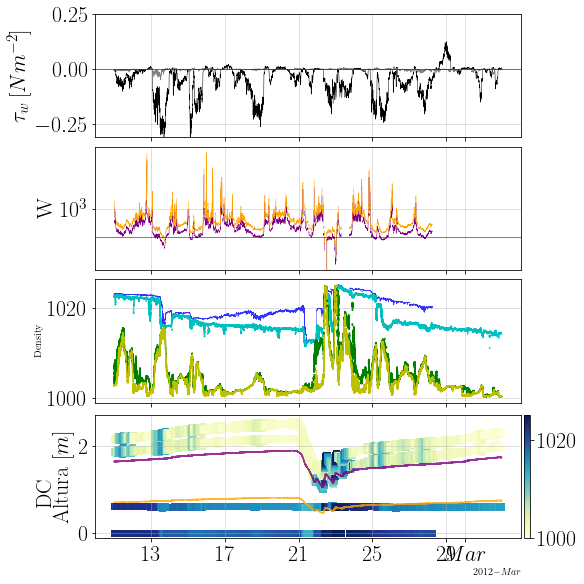

In [37]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax2, ax5, ax3, ax6) = plt.subplots(nrows=4, figsize=(8, 8), constrained_layout=True, sharex=True)

#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)

ax3.plot(dc.time, dc.sel(variables='Density', sensor=1), c='b', alpha=0.8, linewidth=0.5)

dc.sel(variables='Density', sensor=2).plot(ax=ax3, c='c')
dc.sel(variables='Density', sensor=3).plot(ax=ax3, c='g')
dc.sel(variables='Density', sensor=4).plot(ax=ax3, c='y')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.set_title("")
ax3.set_ylabel("Density")
ax3.set_xlabel("")

#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$\tau_w\,[Nm^{-2}]$ ",
          fontsize=22)
ax2.plot(wdf.index, wdf.values,color='k', linewidth=0.5)
ax2.plot(wdv.index, wdv.values,color='grey', linewidth=0.5)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.31, 0.25)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"W",
          fontsize=22)
# ax5.plot(Wu.time, Wu.values, c="purple", lw=0.5)
# ax5.plot(Wd.time, Wd.values, c="orange", lw=0.5)
ax5.semilogy(Wu.time, Wu.values, c="purple", lw=0.5)
ax5.semilogy(Wd.time, Wd.values, c="orange", lw=0.5)
ax5.axhline(y=1, color='k', linewidth=0.5)
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)
ax5.set_title("")
ax5.set_ylabel("W")
ax5.set_xlabel("")
# ax5.set_ylim(0, 10)
ax5.grid(alpha=0.5)
# Grafico densidades DC
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax6.set_ylabel(r"DC \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax6.plot(dc.time, 0.7*dc.sel(variables='Depth', sensor=1), c='purple', alpha=0.8)
ax6.plot(dc.time, 0.3*dc.sel(variables='Depth', sensor=1), c='orange', alpha=0.8)
scat = ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=1), c=dc.sel(variables='Density', sensor=1), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=2), c=dc.sel(variables='Density', sensor=2), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=3), c=dc.sel(variables='Density', sensor=3), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=4), c=dc.sel(variables='Density', sensor=4), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax6, pad=0.007)
cbar2.ax.tick_params(labelsize=22)
ax6.xaxis.set_tick_params(labelsize=22)
ax6.yaxis.set_tick_params(labelsize=22)
ax6.grid(alpha=0.5)


#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

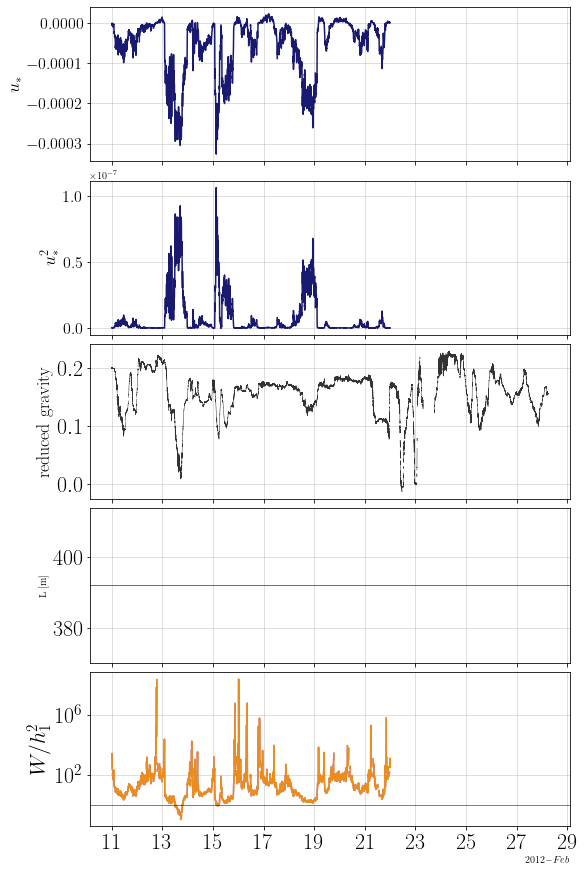

In [29]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax3, ax5) = plt.subplots(nrows=5, figsize=(8, 12), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)

#Grafico de velocidad del agua 

ax1.set_title("")

ax1.plot(u_ast2.time, u_ast2.values, c='midnightblue')
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_ylabel("$u_*$", fontsize=18)
ax1.set_xlabel("")



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)

ax3.axhline(y=L, color='g', linewidth=0.8)

ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.set_title("")
ax3.set_ylabel("L [m]")
ax3.set_xlabel("")

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)

ax4.plot(g_red.time, g_red, c='k', alpha=0.8, linewidth=0.5)

ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.set_title("")
ax4.set_xlabel("")
ax4.set_ylabel(r"reduced gravity ",
          fontsize=18)
#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_title("")

ax2.plot(u_ast2.time, u_ast2.values*u_ast2.values, c='midnightblue')
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.set_ylabel("$u_*^2$", fontsize=18)
ax2.set_xlabel("")

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"W",
          fontsize=22)
# ax5.plot(Wu.time, Wu/h1u**2, c="purple")
# ax5.plot(Wd.time, Wd/h1d**2, c="orange")
ax5.semilogy(Wu.time, Wu/h1u**2, c="purple", alpha=0.8)
ax5.semilogy(Wd.time, Wd/h1d**2, c="orange", alpha=0.8)
ax5.axhline(y=1, color='k', linewidth=0.5)
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)
ax5.set_title("")
ax5.set_ylabel("$W/h_1^2$",
          fontsize=22)
ax5.set_xlabel("")
# ax5.set_ylim(0, 10)
ax5.grid(alpha=0.5)


#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

## Parte 1

In [24]:
bu2 = UV_burst.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00")).u
wdf = tauw['u'].loc[datetime(2012,2,11):datetime(2012,2,22)]
sf = snfco.loc[datetime(2012,2,11):datetime(2012,2,22)]
hm = hmoon.loc[datetime(2012,2,11):datetime(2012,2,22)]
mt = mnty.loc[datetime(2012,2,11):datetime(2012,2,22)]
q = Q.loc[datetime(2012,2,11):datetime(2012,2,22)]

dc = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00")).v
nm = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00")).v
ml = ML_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00")).v
pc = PC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00")).v

y_bin = np.linspace(1.19, 3.59, 25)

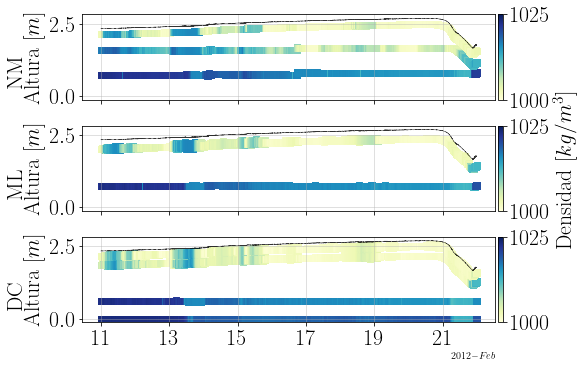

In [25]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax4, ax5, ax3) = plt.subplots(nrows=3, figsize=(8, 5), constrained_layout=True, sharex=True, sharey=True)


#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax3.set_ylabel(r"DC \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax3.plot(dc.time, dc.sel(variables='Depth', sensor=1), c='k', alpha=0.8, linewidth=0.5)
scat = ax3.scatter(dc.time, dc.sel(variables='Depth2', sensor=1), c=dc.sel(variables='Density', sensor=1), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc.time, dc.sel(variables='Depth2', sensor=2), c=dc.sel(variables='Density', sensor=2), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc.time, dc.sel(variables='Depth2', sensor=3), c=dc.sel(variables='Density', sensor=3), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc.time, dc.sel(variables='Depth2', sensor=4), c=dc.sel(variables='Density', sensor=4), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.007)
cbar2.ax.tick_params(labelsize=22)
# cbar2.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)
ax4.set_ylabel(r"NM \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax4.plot(dc.time, dc.sel(variables='Depth', sensor=1), c='k', alpha=0.8, linewidth=0.5)
scat = ax4.scatter(nm.time, nm.sel(variables='Depth2', sensor=1), c=nm.sel(variables='Density', sensor=1), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm.time, nm.sel(variables='Depth2', sensor=2), c=nm.sel(variables='Density', sensor=2), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm.time, nm.sel(variables='Depth2', sensor=3), c=nm.sel(variables='Density', sensor=3), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.007)
cbar3.ax.tick_params(labelsize=22)
# cbar3.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"ML \\ Altura $[m]$",
          fontsize=22)
ax5.plot(dc.time, dc.sel(variables='Depth', sensor=1), c='k', alpha=0.8, linewidth=0.5)
scat = ax5.scatter(ml.time, ml.sel(variables='Depth2', sensor=1), c=ml.sel(variables='Density', sensor=1), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax5.scatter(ml.time, ml.sel(variables='Depth2', sensor=2), c=ml.sel(variables='Density', sensor=2), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.007)
cbar4.ax.tick_params(labelsize=22)
cbar4.set_label("Densidad [$kg/m^3$]", loc='center',
          fontsize=22)
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)


#Ajustar limites colorbar
umin = -0.04
umax = 0.04
vmin = -0.04
vmax = 0.04
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

Como es solo la densidad lo que se está analizando, se considera la altura de la columna de agua del sensor DC en todos los sensores. Esto es para igualar entre los 3 las profundidades y tener una profundidad estándar.

En NM se observa un cambio de densidad en el sensor de al medio lo que podría significar cambio de capa del sensor, es decir que la picnoclina bajó. Este cambio también se puede deber a que los sensores se mueven de lugar un poco más arriba justo cuando cambia, por lo que podría haber cambiado la picnoclina en ese momento.

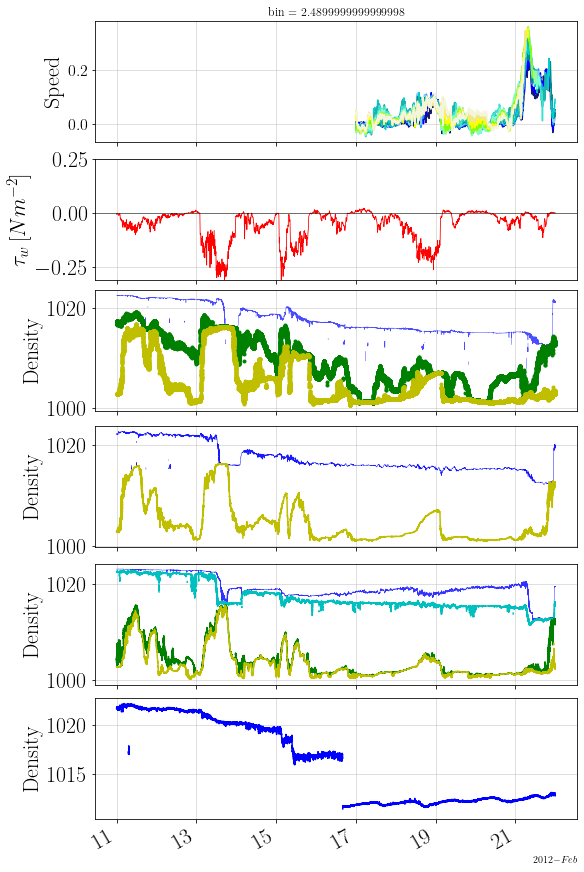

In [58]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6) = plt.subplots(nrows=6, figsize=(8, 12), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)

#Grafico de velocidad del agua 

ax1.set_title("")
bu2.isel(bin=0).plot(ax=ax1, c='midnightblue')
bu2.isel(bin=1).plot(ax=ax1, c='blue')
bu2.isel(bin=2).plot(ax=ax1, c='dodgerblue')
bu2.isel(bin=3).plot(ax=ax1, c='skyblue')
bu2.isel(bin=4).plot(ax=ax1, c='darkcyan')
bu2.isel(bin=5).plot(ax=ax1, c='darkturquoise')
bu2.isel(bin=6).plot(ax=ax1, c='lightseagreen')
bu2.isel(bin=7).plot(ax=ax1, c='turquoise')
bu2.isel(bin=8).plot(ax=ax1, c='aquamarine')
bu2.isel(bin=9).plot(ax=ax1, c='palegreen')
bu2.isel(bin=10).plot(ax=ax1, c='chartreuse')
bu2.isel(bin=11).plot(ax=ax1, c='yellow')
bu2.isel(bin=12).plot(ax=ax1, c='khaki')
bu2.isel(bin=13).plot(ax=ax1, c='beige')



ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_ylabel("Speed", fontsize=22)
ax1.set_xlabel("")



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax3.set_ylabel(r"DC \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax3.plot(dc.time, dc.sel(variables='Density', sensor=1), c='b', alpha=0.8, linewidth=0.5)

dc.sel(variables='Density', sensor=2).plot(ax=ax3, c='c')
dc.sel(variables='Density', sensor=3).plot(ax=ax3, c='g')
dc.sel(variables='Density', sensor=4).plot(ax=ax3, c='y')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.set_title("")
ax3.set_ylabel("Density")
ax3.set_xlabel("")

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)
ax4.set_ylabel(r"NM \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax4.plot(nm.time, nm.sel(variables='Density', sensor=1), c='b', alpha=0.7, linewidth=0.5)
nm.sel(variables='Density', sensor=2).plot(ax=ax4, c='g', marker='.')
nm.sel(variables='Density', sensor=3).plot(ax=ax4, c='y', marker='.')
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.set_title("")
ax4.set_ylabel("Density")
ax4.set_xlabel("")

#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$\tau_w\,[Nm^{-2}]$ ",
          fontsize=22)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.31, 0.25)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"ML \\ Altura $[m]$",
          fontsize=22)
ax5.plot(ml.time, ml.sel(variables='Density', sensor=1), c='b', alpha=0.9, linewidth=0.5)
ml.sel(variables='Density', sensor=2).plot(ax=ax5, c='y')
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)
ax5.set_title("")
ax5.set_ylabel("Density")
ax5.set_xlabel("")

# Grafico densidades PC
pc.sel(variables='Density', sensor=1).plot(ax=ax6, c='b')
ax6.xaxis.set_tick_params(labelsize=22)
ax6.yaxis.set_tick_params(labelsize=22)
ax6.grid(alpha=0.5)
ax6.set_title("")
ax6.set_ylabel("Density", fontsize=22)
ax6.set_xlabel("")

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

## Weddenburn number

### My method:
W: For rectangular basins but can be aproximated (Shintani 2010)
\begin{equation}
W = \frac{g'*h_1^2}{L*u_*^2}
\end{equation}

$h_1$: 30%-70% of DC's total depth (my estimation)

$g'$: reduced gravity (Shintani 2010)

\begin{equation}
g' = \frac{\rho_{bottom} - \rho_{surface}}{\rho_{surface}}*g
\end{equation}

$u_*$: Kinematic shear stress (read 2011)

\begin{equation}
u_*^2 = \frac{\tau_{w}}{\rho_{surface}}
\end{equation}

$\tau_w$ (read 2011): 

\begin{equation}
\tau_w = \rho_{air}*C_D*U_{10}^2
\end{equation}

$U_{10}$: Adjusted from 2 m to 10 m high (read 2011)

\begin{equation}
U_{10} = U_z*\left(1-\frac{C_D^{0.5}}{\kappa}*ln\left(\frac{10}{z}\right)\right)^{-1}
\end{equation}

#### DC

In [25]:
min6_6 = pd.date_range(start=datetime(2012,2,11), end=datetime(2012,2,22), periods=None, freq='6min')

# rho_water = dc.sel(variables='Density').mean('sensor') #se utiliza en u* el promedio de la densidad en todos los sensores
rho_water =  (dc.sel(variables='Density', sensor=4) + dc.sel(variables='Density', sensor=4))/2 #Se utiliza en u* el valor promedio de la capa superficial

g_red = (dc.sel(variables='Density', sensor=1)-dc.sel(variables='Density', sensor=4))*9.81/dc.sel(variables='Density', sensor=4)
rho_air = 1.2

Cd = 0.0014 #Tundisi2002
L = 392 #Obtenido de Google Earth

h1u = 0.3*dc.sel(variables='Depth', sensor=1) # 30% of total depth
h1d = 0.7*dc.sel(variables='Depth', sensor=1) # 70% of total depth
h1c = 0.5*dc.sel(variables='Depth', sensor=1) # 50% of total depth
u_ast2 = (wdf.rename_axis("time").to_xarray()/rho_water.sel(time=min6_6))

Wu = (g_red*h1u**2)/(L*abs(u_ast2))
Wd = (g_red*h1d**2)/(L*abs(u_ast2))
Wc = (g_red*h1c**2)/(L*abs(u_ast2))

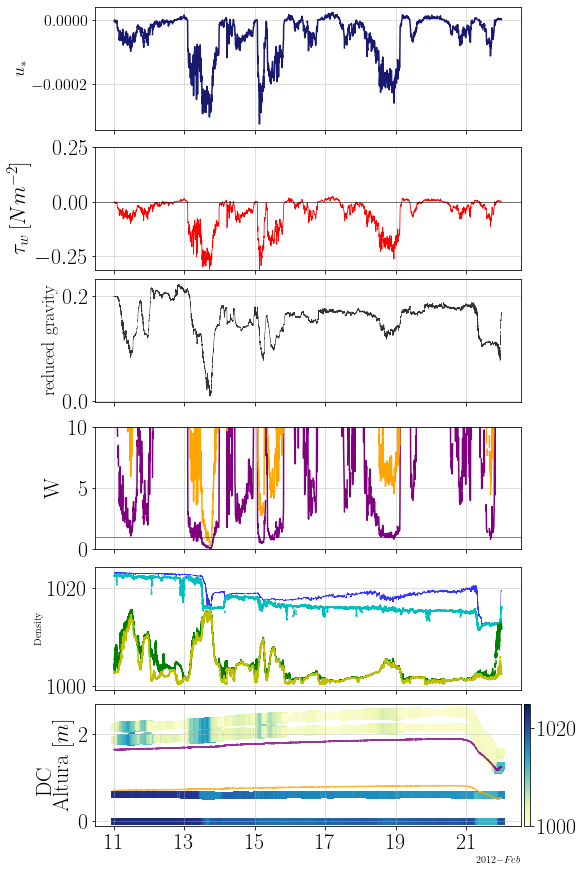

In [26]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6) = plt.subplots(nrows=6, figsize=(8, 12), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)

#Grafico de velocidad del agua 

ax1.set_title("")

ax1.plot(u_ast2.time, u_ast2.values, c='midnightblue')
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_ylabel("$u_*$", fontsize=18)
ax1.set_xlabel("")



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)

ax3.plot(dc.time, dc.sel(variables='Density', sensor=1), c='b', alpha=0.8, linewidth=0.5)

dc.sel(variables='Density', sensor=2).plot(ax=ax3, c='c')
dc.sel(variables='Density', sensor=3).plot(ax=ax3, c='g')
dc.sel(variables='Density', sensor=4).plot(ax=ax3, c='y')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.set_title("")
ax3.set_ylabel("Density")
ax3.set_xlabel("")

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)

ax4.plot(g_red.time, g_red, c='k', alpha=0.8, linewidth=0.5)

ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.set_title("")
ax4.set_xlabel("")
ax4.set_ylabel(r"reduced gravity ",
          fontsize=18)
#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$\tau_w\,[Nm^{-2}]$ ",
          fontsize=22)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.31, 0.25)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"W",
          fontsize=22)
ax5.plot(Wu.time, Wu.values, c="purple")
ax5.plot(Wd.time, Wd.values, c="orange")
# ax5.semilogy(Wu.time, Wu.values, c="purple")
# ax5.semilogy(Wd.time, Wd.values, c="orange")
ax5.axhline(y=1, color='k', linewidth=0.5)
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)
ax5.set_title("")
ax5.set_ylabel("W")
ax5.set_xlabel("")
ax5.set_ylim(0, 10)
ax5.grid(alpha=0.5)
# Grafico densidades DC
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax6.set_ylabel(r"DC \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax6.plot(dc.time, 0.7*dc.sel(variables='Depth', sensor=1), c='purple', alpha=0.8)
ax6.plot(dc.time, 0.3*dc.sel(variables='Depth', sensor=1), c='orange', alpha=0.8)
scat = ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=1), c=dc.sel(variables='Density', sensor=1), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=2), c=dc.sel(variables='Density', sensor=2), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=3), c=dc.sel(variables='Density', sensor=3), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=4), c=dc.sel(variables='Density', sensor=4), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax6, pad=0.007)
cbar2.ax.tick_params(labelsize=22)
ax6.xaxis.set_tick_params(labelsize=22)
ax6.yaxis.set_tick_params(labelsize=22)
ax6.grid(alpha=0.5)


#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

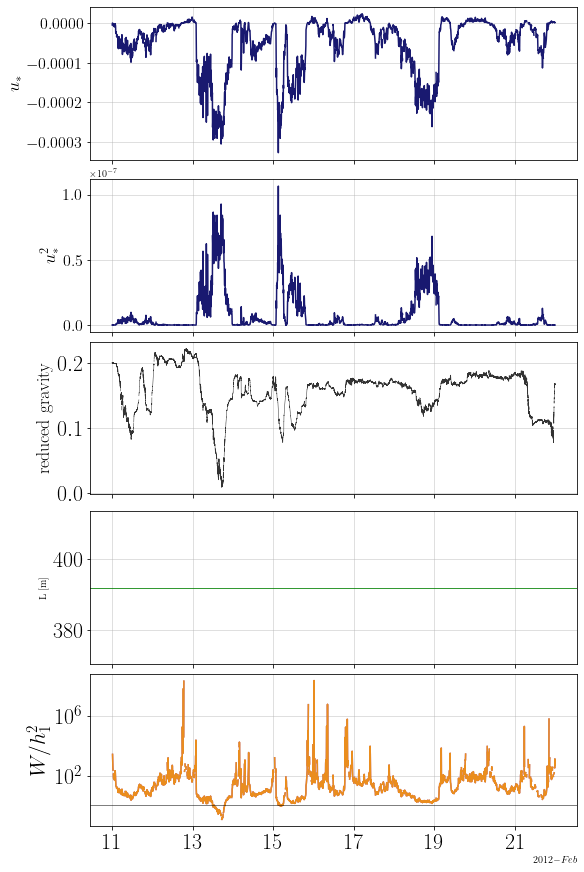

In [34]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax3, ax5) = plt.subplots(nrows=5, figsize=(8, 12), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)

#Grafico de velocidad del agua 

ax1.set_title("")

ax1.plot(u_ast2.time, u_ast2.values, c='midnightblue')
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_ylabel("$u_*$", fontsize=18)
ax1.set_xlabel("")



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)

ax3.axhline(y=L, color='g', linewidth=0.8)

ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.set_title("")
ax3.set_ylabel("L [m]")
ax3.set_xlabel("")

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)

ax4.plot(g_red.time, g_red, c='k', alpha=0.8, linewidth=0.5)

ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.set_title("")
ax4.set_xlabel("")
ax4.set_ylabel(r"reduced gravity ",
          fontsize=18)
#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_title("")

ax2.plot(u_ast2.time, u_ast2.values*u_ast2.values, c='midnightblue')
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.set_ylabel("$u_*^2$", fontsize=18)
ax2.set_xlabel("")

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"W",
          fontsize=22)
# ax5.plot(Wu.time, Wu/h1u**2, c="purple")
# ax5.plot(Wd.time, Wd/h1d**2, c="orange")
ax5.semilogy(Wu.time, Wu/h1u**2, c="purple", alpha=0.8)
ax5.semilogy(Wd.time, Wd/h1d**2, c="orange", alpha=0.8)
ax5.axhline(y=1, color='k', linewidth=0.5)
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)
ax5.set_title("")
ax5.set_ylabel("$W/h_1^2$",
          fontsize=22)
ax5.set_xlabel("")
# ax5.set_ylim(0, 10)
ax5.grid(alpha=0.5)


#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

#### NM

In [35]:
min6_1 = pd.date_range(start=datetime(2012,2,11), end=datetime(2012,2,22), periods=None, freq='6min')
min6_2 = pd.date_range(start=datetime(2012,2,11), end=datetime(2012,2,16), periods=None, freq='6min')
min6_3 = pd.date_range(start=datetime(2012,2,16), end=datetime(2012,2,22), periods=None, freq='6min')

rho_water = nm.sel(variables='Density').mean('sensor') #se utiliza en u* el promedio de la densidad en todos los sensores
# rho_water =  (nm.sel(variables='Density', sensor=3) + nm.sel(variables='Density', sensor=2))/2 #Se utiliza en u* el valor promedio de la capa superficial

g_red = (nm.sel(variables='Density', sensor=1)-nm.sel(variables='Density', sensor=3))*9.81/nm.sel(variables='Density', sensor=3)
rho_air = 1.2

Cd = 0.0014 #Tundisi2002
L = 392 #Obtenido de Google Earth

h1u = 0.3*dc.sel(variables='Depth', sensor=1) # 30% of total depth
h1d = 0.65*dc.sel(variables='Depth', sensor=1) # 65% of total depth
h1c = 0.4*dc.sel(variables='Depth', sensor=1) # 40% of total depth
u_ast1 = (wdf.rename_axis("time").to_xarray()/rho_water.sel(time=min6_1))
u_ast2 = (wdf.rename_axis("time").to_xarray()/rho_water.sel(time=min6_2))
u_ast3 = (wdf.rename_axis("time").to_xarray()/rho_water.sel(time=min6_3))

Wu = (g_red*h1u**2)/(L*abs(u_ast2))
Wd = (g_red*h1d**2)/(L*abs(u_ast1))
Wc = (g_red*h1c**2)/(L*abs(u_ast3))

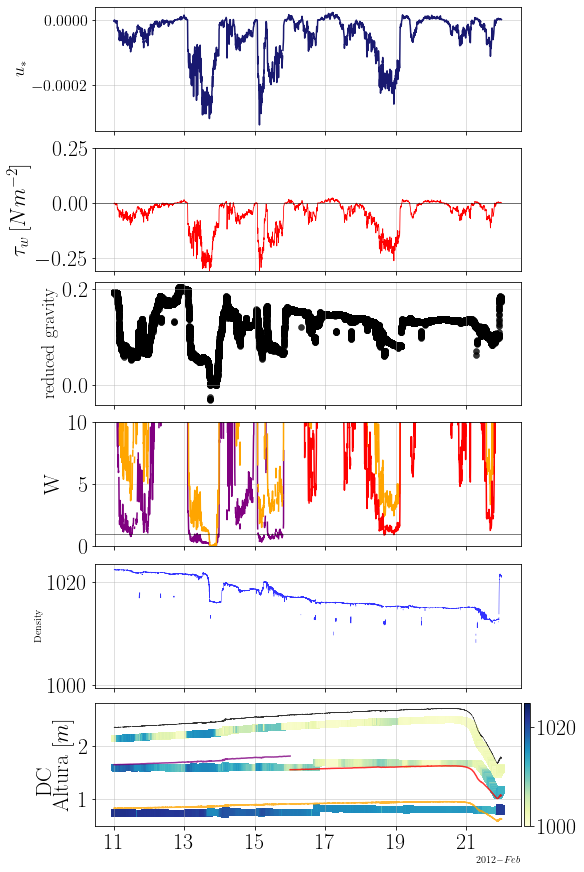

In [36]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6) = plt.subplots(nrows=6, figsize=(8, 12), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)

#Grafico de velocidad del agua 

ax1.set_title("")

ax1.plot(u_ast1.time, u_ast1.values, c='midnightblue')
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_ylabel("$u_*$", fontsize=18)
ax1.set_xlabel("")



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)

ax3.plot(nm.time, nm.sel(variables='Density', sensor=1), c='b', alpha=0.8, linewidth=0.5)

nm.sel(variables='Density', sensor=2).plot(ax=ax3, c='g')
nm.sel(variables='Density', sensor=3).plot(ax=ax3, c='y')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.set_title("")
ax3.set_ylabel("Density")
ax3.set_xlabel("")


ax4.scatter(g_red.time, g_red, c='k', alpha=0.8, linewidth=0.5)

ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.set_title("")
ax4.set_xlabel("")
ax4.set_ylabel(r"reduced gravity ",
          fontsize=18)
#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$\tau_w\,[Nm^{-2}]$ ",
          fontsize=22)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.31, 0.25)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"W",
          fontsize=22)
ax5.plot(Wu.time, Wu.values, c="purple")
ax5.plot(Wd.time, Wd.values, c="orange")
ax5.plot(Wc.time, Wc.values, c="r")
# ax5.semilogy(Wu.time, Wu.values, c="purple")
# ax5.semilogy(Wd.time, Wd.values, c="orange")
ax5.axhline(y=1, color='k', linewidth=0.5)
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)
ax5.set_title("")
ax5.set_ylabel("W")
ax5.set_xlabel("")
ax5.set_ylim(0, 10)
ax5.grid(alpha=0.5)
# Grafico densidades DC
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax6.set_ylabel(r"DC \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax6.plot(min6_2, 0.7*dc.sel(variables='Depth', sensor=1, time=min6_2), c='purple', alpha=0.8)
ax6.plot(dc.time, 0.35*dc.sel(variables='Depth', sensor=1), c='orange', alpha=0.8)
ax6.plot(min6_3, 0.6*dc.sel(variables='Depth', sensor=1, time=min6_3), c='r', alpha=0.8)
ax6.plot(dc.time, dc.sel(variables='Depth', sensor=1), c='k', alpha=0.8, linewidth=0.5)
scat = ax6.scatter(nm.time.values, nm.sel(variables='Depth2', sensor=1), c=nm.sel(variables='Density', sensor=1), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(nm.time.values, nm.sel(variables='Depth2', sensor=2), c=nm.sel(variables='Density', sensor=2), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(nm.time.values, nm.sel(variables='Depth2', sensor=3), c=nm.sel(variables='Density', sensor=3), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax6, pad=0.007)
cbar2.ax.tick_params(labelsize=22)
ax6.xaxis.set_tick_params(labelsize=22)
ax6.yaxis.set_tick_params(labelsize=22)
ax6.grid(alpha=0.5)


#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

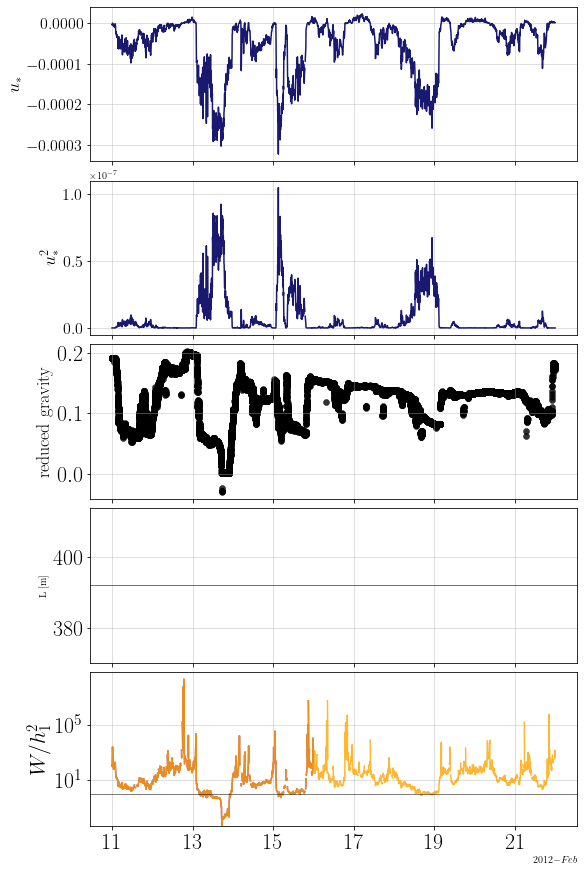

In [39]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax3, ax5) = plt.subplots(nrows=5, figsize=(8, 12), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)

#Grafico de velocidad del agua 

ax1.set_title("")

ax1.plot(u_ast1.time, u_ast1.values, c='midnightblue')
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_ylabel("$u_*$", fontsize=18)
ax1.set_xlabel("")



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)

ax3.axhline(y=L, color='g', linewidth=0.8)

ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.set_title("")
ax3.set_ylabel("L [m]")
ax3.set_xlabel("")

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)

ax4.scatter(g_red.time, g_red, c='k', alpha=0.8, linewidth=0.5)

ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.set_title("")
ax4.set_xlabel("")
ax4.set_ylabel(r"reduced gravity ",
          fontsize=18)
#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_title("")

ax2.plot(u_ast1.time, u_ast1.values*u_ast1.values, c='midnightblue')
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.set_ylabel("$u_*^2$", fontsize=18)
ax2.set_xlabel("")

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"W",
          fontsize=22)
# ax5.plot(Wu.time, Wu/h1u**2, c="purple")
# ax5.plot(Wd.time, Wd/h1d**2, c="orange")
ax5.semilogy(Wu.time, Wu/h1u**2, c="purple", alpha=0.8)
ax5.semilogy(Wd.time, Wd/h1d**2, c="orange", alpha=0.8)
ax5.axhline(y=1, color='k', linewidth=0.5)
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)
ax5.set_title("")
ax5.set_ylabel("$W/h_1^2$",
          fontsize=22)
ax5.set_xlabel("")
# ax5.set_ylim(0, 10)
ax5.grid(alpha=0.5)


#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

#### ML

In [40]:
min6_1 = pd.date_range(start=datetime(2012,2,11), end=datetime(2012,2,22), periods=None, freq='6min')
min6_2 = pd.date_range(start=datetime(2012,2,11), end=datetime(2012,2,16), periods=None, freq='6min')
min6_3 = pd.date_range(start=datetime(2012,2,16), end=datetime(2012,2,22), periods=None, freq='6min')

rho_water = ml.sel(variables='Density').mean('sensor') #se utiliza en u* el promedio de la densidad en todos los sensores
# rho_water =  (nm.sel(variables='Density', sensor=3) + nm.sel(variables='Density', sensor=2))/2 #Se utiliza en u* el valor promedio de la capa superficial

g_red = (ml.sel(variables='Density', sensor=1)-ml.sel(variables='Density', sensor=2))*9.81/ml.sel(variables='Density', sensor=2)
rho_air = 1.2

Cd = 0.0014 #Tundisi2002
L = 392 #Obtenido de Google Earth

h1u = 0.3*dc.sel(variables='Depth', sensor=1) # 30% of total depth
h1d = 0.65*dc.sel(variables='Depth', sensor=1) # 65% of total depth
h1c = 0.4*dc.sel(variables='Depth', sensor=1) # 40% of total depth
u_ast1 = (wdf.rename_axis("time").to_xarray()/rho_water.sel(time=min6_1))
u_ast2 = (wdf.rename_axis("time").to_xarray()/rho_water.sel(time=min6_2))
u_ast3 = (wdf.rename_axis("time").to_xarray()/rho_water.sel(time=min6_3))

Wu = (g_red*h1u**2)/(L*abs(u_ast2))
Wd = (g_red*h1d**2)/(L*abs(u_ast1))
Wc = (g_red*h1c**2)/(L*abs(u_ast3))

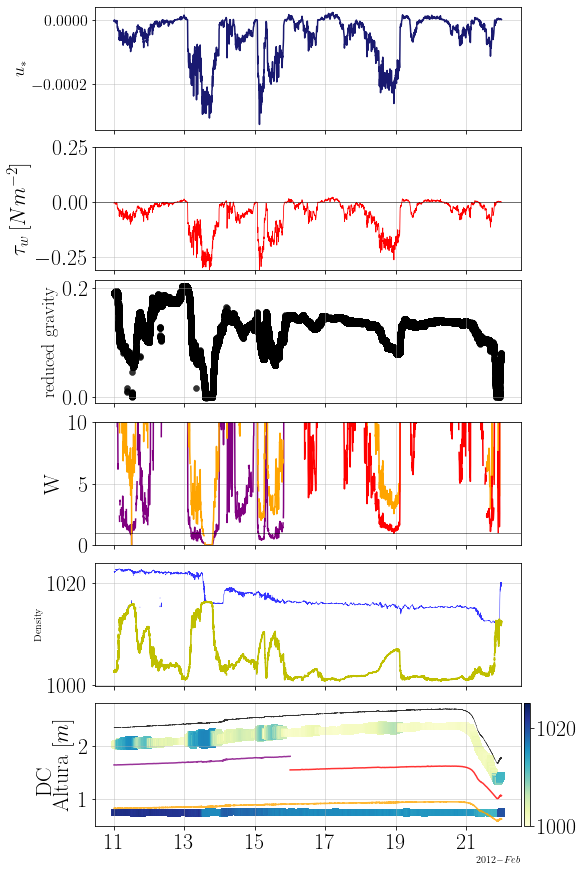

In [41]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6) = plt.subplots(nrows=6, figsize=(8, 12), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)

#Grafico de velocidad del agua 

ax1.set_title("")

ax1.plot(u_ast1.time, u_ast1.values, c='midnightblue')
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_ylabel("$u_*$", fontsize=18)
ax1.set_xlabel("")



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)

ax3.plot(ml.time, ml.sel(variables='Density', sensor=1), c='b', alpha=0.8, linewidth=0.5)

ml.sel(variables='Density', sensor=2).plot(ax=ax3, c='y')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.set_title("")
ax3.set_ylabel("Density")
ax3.set_xlabel("")


ax4.scatter(g_red.time, g_red, c='k', alpha=0.8, linewidth=0.5)

ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.set_title("")
ax4.set_xlabel("")
ax4.set_ylabel(r"reduced gravity ",
          fontsize=18)
#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$\tau_w\,[Nm^{-2}]$ ",
          fontsize=22)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.31, 0.25)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"W",
          fontsize=22)
ax5.plot(Wu.time, Wu.values, c="purple")
ax5.plot(Wd.time, Wd.values, c="orange")
ax5.plot(Wc.time, Wc.values, c="r")
# ax5.semilogy(Wu.time, Wu.values, c="purple")
# ax5.semilogy(Wd.time, Wd.values, c="orange")
ax5.axhline(y=1, color='k', linewidth=0.5)
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)
ax5.set_title("")
ax5.set_ylabel("W")
ax5.set_xlabel("")
ax5.set_ylim(0, 10)
ax5.grid(alpha=0.5)
# Grafico densidades DC
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax6.set_ylabel(r"DC \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax6.plot(min6_2, 0.7*dc.sel(variables='Depth', sensor=1, time=min6_2), c='purple', alpha=0.8)
ax6.plot(dc.time, 0.35*dc.sel(variables='Depth', sensor=1), c='orange', alpha=0.8)
ax6.plot(min6_3, 0.6*dc.sel(variables='Depth', sensor=1, time=min6_3), c='r', alpha=0.8)
ax6.plot(dc.time, dc.sel(variables='Depth', sensor=1), c='k', alpha=0.8, linewidth=0.5)
scat = ax6.scatter(ml.time.values, ml.sel(variables='Depth2', sensor=1), c=ml.sel(variables='Density', sensor=1), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(ml.time.values, ml.sel(variables='Depth2', sensor=2), c=ml.sel(variables='Density', sensor=2), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax6, pad=0.007)
cbar2.ax.tick_params(labelsize=22)
ax6.xaxis.set_tick_params(labelsize=22)
ax6.yaxis.set_tick_params(labelsize=22)
ax6.grid(alpha=0.5)


#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

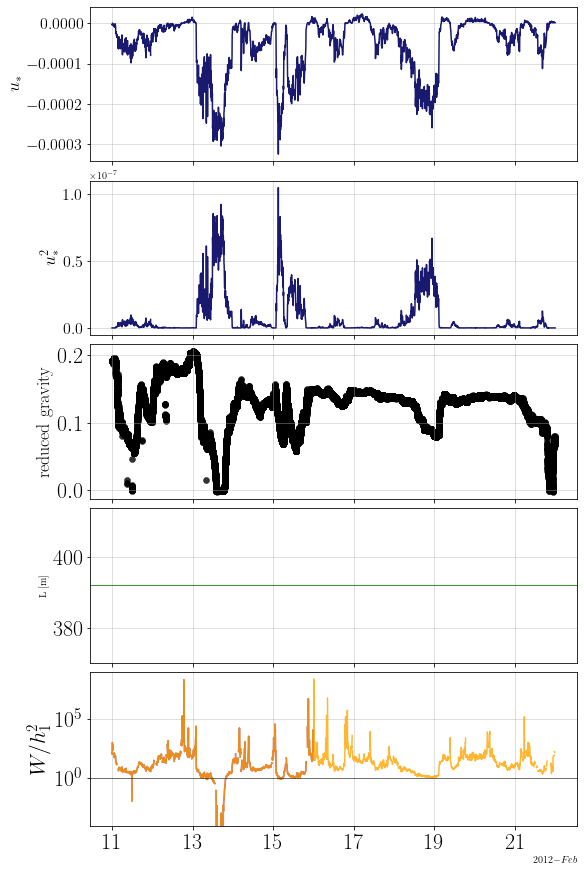

In [42]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax3, ax5) = plt.subplots(nrows=5, figsize=(8, 12), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)

#Grafico de velocidad del agua 

ax1.set_title("")

ax1.plot(u_ast1.time, u_ast1.values, c='midnightblue')
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_ylabel("$u_*$", fontsize=18)
ax1.set_xlabel("")



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)

ax3.axhline(y=L, color='g', linewidth=0.8)

ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.set_title("")
ax3.set_ylabel("L [m]")
ax3.set_xlabel("")

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)

ax4.scatter(g_red.time, g_red, c='k', alpha=0.8, linewidth=0.5)

ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.set_title("")
ax4.set_xlabel("")
ax4.set_ylabel(r"reduced gravity ",
          fontsize=18)
#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_title("")

ax2.plot(u_ast1.time, u_ast1.values*u_ast1.values, c='midnightblue')
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.set_ylabel("$u_*^2$", fontsize=18)
ax2.set_xlabel("")

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"W",
          fontsize=22)
# ax5.plot(Wu.time, Wu/h1u**2, c="purple")
# ax5.plot(Wd.time, Wd/h1d**2, c="orange")
ax5.semilogy(Wu.time, Wu/h1u**2, c="purple", alpha=0.8)
ax5.semilogy(Wd.time, Wd/h1d**2, c="orange", alpha=0.8)
ax5.axhline(y=1, color='k', linewidth=0.5)
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)
ax5.set_title("")
ax5.set_ylabel("$W/h_1^2$",
          fontsize=22)
ax5.set_xlabel("")
# ax5.set_ylim(0, 10)
ax5.grid(alpha=0.5)


#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

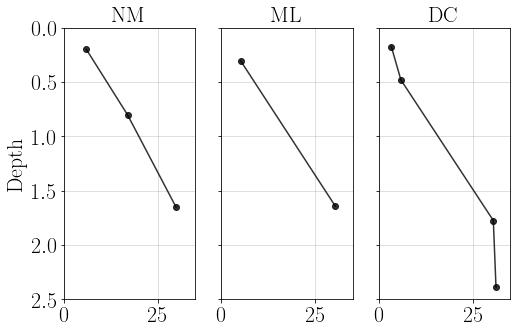

In [34]:
min6_6 = pd.date_range(start=datetime(2012,2,12,12,0,0), end=datetime(2012,2,14,12,0,0), periods=None, freq='6min')

wdf = dfw['u'].loc[datetime(2012,2,12,12,0,0):datetime(2012,2,14,12,0,0)]

dc = DC_CTD.sel(time=min6_6).v
nm = NM_CTD.sel(time=min6_6).v
ml = ML_CTD.sel(time=min6_6).v
pc = PC_CTD.sel(time=min6_6).v


#Inicio figura
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8, 5), sharex=True, sharey=True)


#Perfil NM
ax1.set_title(r"NM",
          fontsize=22)
ax1.set_ylabel(r"Depth",
          fontsize=22)


ax1.plot(nm.sel(variables='Sal_del').isel(time=10), nm.sel(variables= 'Depth').isel(time=0), c='k', alpha=0.8, marker='o')

ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax1.grid(alpha=0.5)
ax1.set_ylim(0, 2.5)
ax1.set_xlim(0, 35)
ax1.invert_yaxis()

#Perfil ML
ax2.set_title(r"ML",
          fontsize=22)


ax2.plot(ml.sel(variables='Sal_del').isel(time=10), ml.sel(variables= 'Depth').isel(time=0), c='k', alpha=0.8, marker='o')

ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.invert_yaxis()
ax2.set_ylim(0, 2.5)
ax2.set_xlim(0, 35)
ax2.invert_yaxis()

# Perfil DC
ax3.set_title(r"DC",
          fontsize=22)


ax3.plot(dc.sel(variables='Sal_del').isel(time=10), dc.sel(variables= 'Depth').isel(time=0), c='k', alpha=0.8, marker='o')

ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.invert_yaxis()
ax3.set_ylim(0, 2.5)
ax3.set_xlim(0, 35)
ax3.invert_yaxis()


# Ajustar formato fecha
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

### Stevens and Imberger's method (1997) 

A crucial point when considering the usefulness of W and L, is that they are steady-state parameters. As the response is characterized by an internal standing wave of the gravest horizontal mode, the long-wave speed

\begin{equation}
c_l=\left(\frac{\epsilon gh_1 h_2}{h_1 + h_2 }\right)^{1/2}
\end{equation}


limits the rapidity of the tilting. Spigel & Imberger (1980) showed that, after commencement of the stress, it takes $1/4$ of the internal wave period

\begin{equation}
T_1 = 2L/c_l
\end{equation}

for the condition identified by W to occur.


2.3. Unsteadiness 

With more than one vertical wave mode the time-scales for maximum shear and tilt (i.e. $\frac{1}{4}T_1$ and $\frac{1}{2}T_1$ as identified by Spigel & Imberger 1980) are replaced by $T_i$ where the index represents the ith vertical mode. The appropriate non-dimensional ratio delineating whether the wind duration is of sufficient duration to allow tilting due to the ith mode to fully develop is 

\begin{equation}
\frac{4T_w}{T_i}
\end{equation}

where $T_w$, is the wind duration. A practical consideration related to this growth timescale is that a $u_*$ time-series should first be low-pass filtered with a filter time constant $~\frac{1}{4}T_1$ before a time-series of W or $L_N$, is calculated (Stevens et al. 1996).

** As h1 and h2 are changing, to find T1 I averaged all T1 calculated for each time-step. **


In [61]:
h2 = 0.7*dc.sel(variables='Depth', sensor=1) # 70% of total depth
cl = (g_red*h1u*h2/(h1u+h2))**0.5
T1 = 2*L/cl
T1.mean()//4
## I'm going to approximate T/4 to 12 minutes
T4 = 12 #min

In [62]:
## Low-pass filter functions
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [63]:
# Filter requirements.
order = 6
cutoff = (T1.mean()//2)**(-1)  # desired cutoff frequency of the filter, Hz

# Filtrado de datos
u_star_lpf = butter_lowpass_filter(u_ast2.values, cutoff, fs=1/360, order=6)

Text(0.5, 0, '')

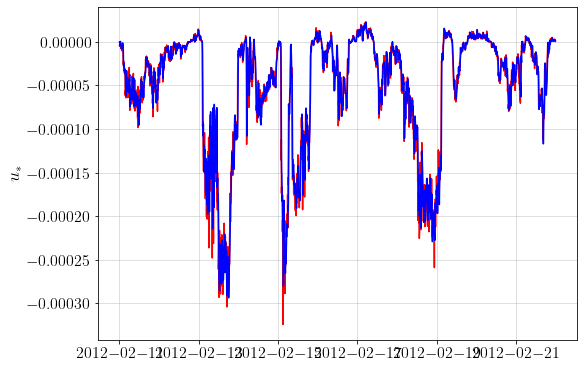

In [64]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1) = plt.subplots(nrows=1, figsize=(8, 5), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)

#Grafico de velocidad del agua 

ax1.set_title("")
ax1.plot(u_ast2.time, u_ast2.values, c="r")
ax1.plot(u_ast2.time, u_star_lpf, c="b")


ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_ylabel("$u_*$", fontsize=18)
ax1.set_xlabel("")


In [65]:
## time-dynamic back-looking averaging window

dt = min6_6 - timedelta(minutes=12)
u_star = pd.DataFrame(data={'ustar': u_star_lpf}, index = dt)


,ustar
2012-02-10 23:48:00,-1.326347e-07
2012-02-10 23:54:00,-9.417901e-07
2012-02-11 00:00:00,-2.763669e-06
2012-02-11 00:06:00,-4.128136e-06
2012-02-11 00:12:00,-2.852581e-06
...,...
2012-02-21 23:24:00,2.857985e-06
2012-02-21 23:30:00,2.796931e-06
2012-02-21 23:36:00,1.798990e-06
2012-02-21 23:42:00,1.049950e-06


In [66]:
min6_6 = pd.date_range(start=datetime(2012,2,11), end=datetime(2012,2,22), periods=None, freq='6min')

rho_water = dc.sel(variables='Density').mean('sensor')

g_red = (dc.sel(variables='Density', sensor=1)-dc.sel(variables='Density', sensor=4))*9.81/dc.sel(variables='Density', sensor=4)
rho_air = 1.2

Cd = 0.0014 #Tundisi2002
L = 392 #Obtenido de Google Earth

h1u = 0.3*dc.sel(variables='Depth', sensor=1) # 30% of total depth
h1d = 0.7*dc.sel(variables='Depth', sensor=1) # 70% of total depth
h1c = 0.5*dc.sel(variables='Depth', sensor=1) # 50% of total depth
u_star2 = u_star.rename_axis("time").to_xarray()

Wu = (g_red*h1u**2)/(L*abs(u_star2))
Wd = (g_red*h1d**2)/(L*abs(u_star2))
Wc = (g_red*h1c**2)/(L*abs(u_star2))

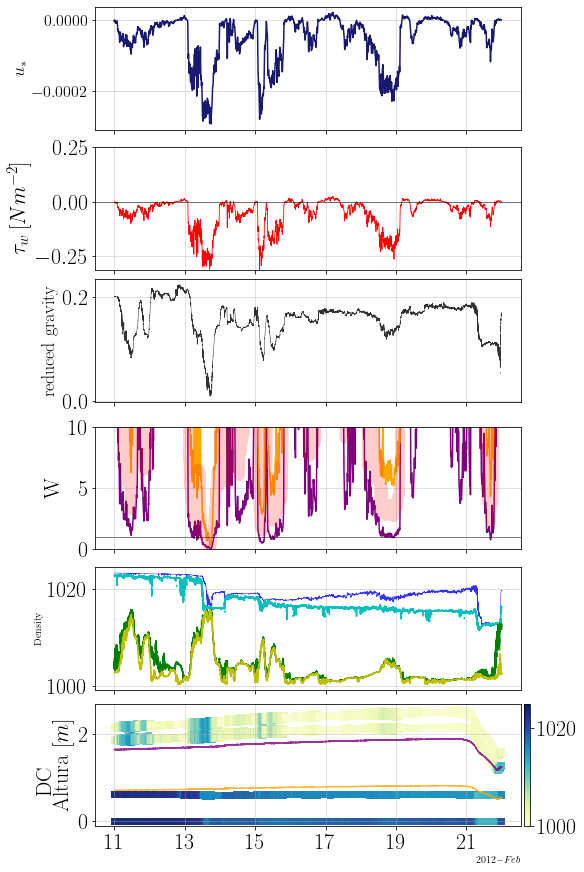

In [75]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6) = plt.subplots(nrows=6, figsize=(8, 12), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)

#Grafico de velocidad del agua 

ax1.set_title("")

ax1.plot(u_star2.time, u_star2.ustar, c='midnightblue')
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_ylabel("$u_*$", fontsize=18)
ax1.set_xlabel("")



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)

ax3.plot(dc.time, dc.sel(variables='Density', sensor=1), c='b', alpha=0.8, linewidth=0.5)

dc.sel(variables='Density', sensor=2).plot(ax=ax3, c='c')
dc.sel(variables='Density', sensor=3).plot(ax=ax3, c='g')
dc.sel(variables='Density', sensor=4).plot(ax=ax3, c='y')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.set_title("")
ax3.set_ylabel("Density")
ax3.set_xlabel("")

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)

ax4.plot(g_red.time, g_red, c='k', alpha=0.8, linewidth=0.5)

ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.set_title("")
ax4.set_xlabel("")
ax4.set_ylabel(r"reduced gravity ",
          fontsize=18)
#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$\tau_w\,[Nm^{-2}]$ ",
          fontsize=22)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.31, 0.25)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"W",
          fontsize=22)
ax5.plot(Wu.time, Wu.ustar, c='purple')
ax5.plot(Wd.time, Wd.ustar, c='orange')
ax5.plot(Wc.time, Wc.ustar, c='r', lw=10, alpha=0.2)
# ax5.plot(ml.time, ml.sel(variables='Density', sensor=1), c='b', alpha=0.9, linewidth=0.5)

ax5.axhline(y=1, color='k', linewidth=0.5)
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)
ax5.set_title("")
ax5.set_ylabel("W")
ax5.set_xlabel("")
ax5.set_ylim(0, 10)
ax5.grid(alpha=0.5)
# Grafico densidades DC
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax6.set_ylabel(r"DC \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax6.plot(dc.time, 0.7*dc.sel(variables='Depth', sensor=1), c='purple', alpha=0.8)
ax6.plot(dc.time, 0.3*dc.sel(variables='Depth', sensor=1), c='orange', alpha=0.8)
scat = ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=1), c=dc.sel(variables='Density', sensor=1), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=2), c=dc.sel(variables='Density', sensor=2), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=3), c=dc.sel(variables='Density', sensor=3), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=4), c=dc.sel(variables='Density', sensor=4), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax6, pad=0.007)
cbar2.ax.tick_params(labelsize=22)
ax6.xaxis.set_tick_params(labelsize=22)
ax6.yaxis.set_tick_params(labelsize=22)
ax6.grid(alpha=0.5)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

## Parte 2

In [43]:
bu2 = UV_burst.sel(time=slice("2012-02-24 00:00:00","2012-03-03 00:00:00")).u
wdf = tauw['u'].loc[datetime(2012,2,24):datetime(2012,3,3)]
sf = snfco.loc[datetime(2012,2,24):datetime(2012,3,3)]
hm = hmoon.loc[datetime(2012,2,24):datetime(2012,3,3)]
mt = mnty.loc[datetime(2012,2,24):datetime(2012,3,3)]
q = Q.loc[datetime(2012,2,24):datetime(2012,3,3)]

dc = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-03 00:00:00")).v
nm = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-03 00:00:00")).v
ml = ML_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-03 00:00:00")).v
pc = PC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-03 00:00:00")).v

y_bin = np.linspace(1.19, 3.59, 25)

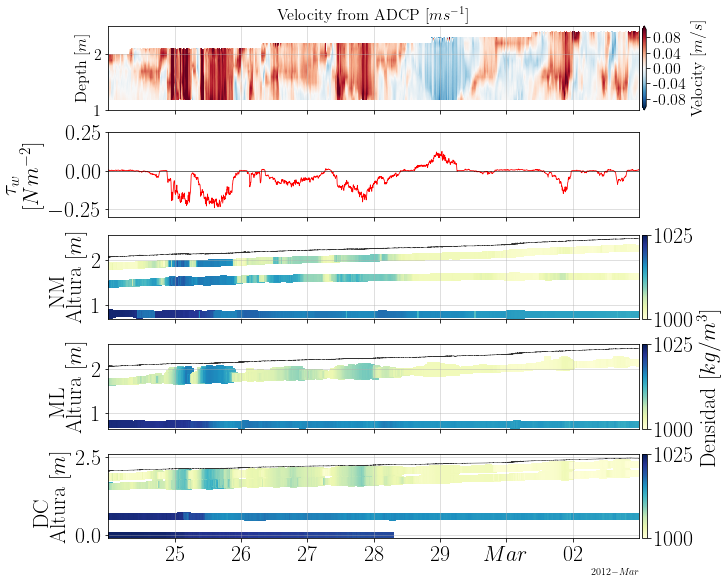

In [58]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3) = plt.subplots(nrows=5, figsize=(10, 8), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)
# gs = GridSpec(14, 1, figure=fig)

#Grafico de velocidad del agua (color map)
# ax1 = fig.add_subplot(gs[:3, 0])
ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
          fontsize=16)
contourf_ = ax1.contourf(bu2.time, y_bin,
                         np.transpose(bu2.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.007)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.04))
cbar.set_label("Velocity [$m/s$]", loc='center',
          fontsize=16)
ax1.set_ylabel(r"Depth "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax3.set_ylabel(r"DC \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax3.plot(dc.time, dc.sel(variables='Depth', sensor=1), c='k', alpha=0.8, linewidth=0.5)
scat = ax3.scatter(dc.time, dc.sel(variables='Depth2', sensor=1), c=dc.sel(variables='Density', sensor=1), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc.time, dc.sel(variables='Depth2', sensor=2), c=dc.sel(variables='Density', sensor=2), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc.time, dc.sel(variables='Depth2', sensor=3), c=dc.sel(variables='Density', sensor=3), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc.time, dc.sel(variables='Depth2', sensor=4), c=dc.sel(variables='Density', sensor=4), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.007)
cbar2.ax.tick_params(labelsize=22)
# cbar2.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)
ax4.set_ylabel(r"NM \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax4.plot(dc.time, dc.sel(variables='Depth', sensor=1), c='k', alpha=0.8, linewidth=0.5)
scat = ax4.scatter(nm.time, nm.sel(variables='Depth2', sensor=1), c=nm.sel(variables='Density', sensor=1), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm.time, nm.sel(variables='Depth2', sensor=2), c=nm.sel(variables='Density', sensor=2), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm.time, nm.sel(variables='Depth2', sensor=3), c=nm.sel(variables='Density', sensor=3), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.007)
cbar3.ax.tick_params(labelsize=22)
# cbar3.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$\tau_w$\\$[Nm^{-2}]$ ",
          fontsize=22)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.3, 0.25)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"ML \\ Altura $[m]$",
          fontsize=22)
ax5.plot(dc.time, dc.sel(variables='Depth', sensor=1), c='k', alpha=0.8, linewidth=0.5)
scat = ax5.scatter(ml.time, ml.sel(variables='Depth2', sensor=1), c=ml.sel(variables='Density', sensor=1), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax5.scatter(ml.time, ml.sel(variables='Depth2', sensor=2), c=ml.sel(variables='Density', sensor=2), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.007)
cbar4.ax.tick_params(labelsize=22)
cbar4.set_label("Densidad [$kg/m^3$]", loc='center',
          fontsize=22)
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)


#Ajustar limites colorbar
umin = -0.04
umax = 0.04
vmin = -0.04
vmax = 0.04
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

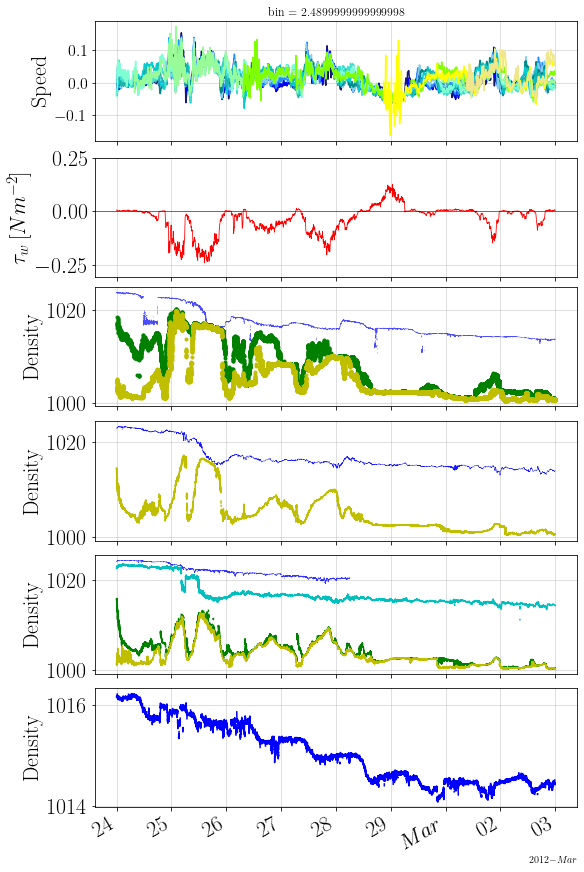

In [27]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6) = plt.subplots(nrows=6, figsize=(8, 12), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)

#Grafico de velocidad del agua 

ax1.set_title("")
bu2.isel(bin=0).plot(ax=ax1, c='midnightblue')
bu2.isel(bin=1).plot(ax=ax1, c='blue')
bu2.isel(bin=2).plot(ax=ax1, c='dodgerblue')
bu2.isel(bin=3).plot(ax=ax1, c='skyblue')
bu2.isel(bin=4).plot(ax=ax1, c='darkcyan')
bu2.isel(bin=5).plot(ax=ax1, c='darkturquoise')
bu2.isel(bin=6).plot(ax=ax1, c='lightseagreen')
bu2.isel(bin=7).plot(ax=ax1, c='turquoise')
bu2.isel(bin=8).plot(ax=ax1, c='aquamarine')
bu2.isel(bin=9).plot(ax=ax1, c='palegreen')
bu2.isel(bin=10).plot(ax=ax1, c='chartreuse')
bu2.isel(bin=11).plot(ax=ax1, c='yellow')
bu2.isel(bin=12).plot(ax=ax1, c='khaki')
bu2.isel(bin=13).plot(ax=ax1, c='beige')



ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_ylabel("Speed", fontsize=22)
ax1.set_xlabel("")



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax3.set_ylabel(r"DC \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax3.plot(dc.time, dc.sel(variables='Density', sensor=1), c='b', alpha=0.8, linewidth=0.5)

dc.sel(variables='Density', sensor=2).plot(ax=ax3, c='c')
dc.sel(variables='Density', sensor=3).plot(ax=ax3, c='g')
dc.sel(variables='Density', sensor=4).plot(ax=ax3, c='y')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.set_title("")
ax3.set_ylabel("Density")
ax3.set_xlabel("")

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)
ax4.set_ylabel(r"NM \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax4.plot(nm.time, nm.sel(variables='Density', sensor=1), c='b', alpha=0.7, linewidth=0.5)
nm.sel(variables='Density', sensor=2).plot(ax=ax4, c='g', marker='.')
nm.sel(variables='Density', sensor=3).plot(ax=ax4, c='y', marker='.')
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.set_title("")
ax4.set_ylabel("Density")
ax4.set_xlabel("")

#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$\tau_w\,[Nm^{-2}]$ ",
          fontsize=22)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.31, 0.25)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"ML \\ Altura $[m]$",
          fontsize=22)
ax5.plot(ml.time, ml.sel(variables='Density', sensor=1), c='b', alpha=0.9, linewidth=0.5)
ml.sel(variables='Density', sensor=2).plot(ax=ax5, c='y')
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)
ax5.set_title("")
ax5.set_ylabel("Density")
ax5.set_xlabel("")

# Grafico densidades PC
pc.sel(variables='Density', sensor=1).plot(ax=ax6, c='b')
ax6.xaxis.set_tick_params(labelsize=22)
ax6.yaxis.set_tick_params(labelsize=22)
ax6.grid(alpha=0.5)
ax6.set_title("")
ax6.set_ylabel("Density", fontsize=22)
ax6.set_xlabel("")

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

## Weddenburn number

### My method:

\begin{equation}
W = \frac{g'*h_1^2}{L*u_*^2}
\end{equation}

For rectangular basin but can be aproximated 

$h_1$: 30% of total depth 

$g'$: reduced gravity

\begin{equation}
g' = \frac{\rho_{bottom} - \rho_{surface}}{\rho_{surface}}*g
\end{equation}

$u_*$: Kinematic shear stress

\begin{equation}
u_*^2 = \frac{\tau_{w}}{\rho_{water}}
\end{equation}

$\tau_w$: 

\begin{equation}
\tau_w = \rho_{air}*C_D*U_{10}^2
\end{equation}

$U_{10}$: Adjusted from 2 m to 10 m high

\begin{equation}
U_{10} = U_z*\left(1-\frac{C_D^{0.5}}{\kappa}*ln\left(\frac{10}{z}\right)\right)^{-1}
\end{equation}

### DC

In [44]:
min6_6 = pd.date_range(start=datetime(2012,2,24), end=datetime(2012,3,3), periods=None, freq='6min')

rho_water = dc.sel(variables='Density').mean('sensor')

g_red = (dc.sel(variables='Density', sensor=1)-dc.sel(variables='Density', sensor=4))*9.81/dc.sel(variables='Density', sensor=4)
rho_air = 1.2

Cd = 0.0014 #Tundisi2002
L = 392 #Obtenido de Google Earth

h1u = 0.3*dc.sel(variables='Depth', sensor=1) # 30% of total depth
h1d = 0.7*dc.sel(variables='Depth', sensor=1) # 70% of total depth
h1c = 0.5*dc.sel(variables='Depth', sensor=1) # 50% of total depth
u_ast2 = (wdf.rename_axis("time").to_xarray()/rho_water.sel(time=min6_6))

Wu = (g_red*h1u**2)/(L*abs(u_ast2))
Wd = (g_red*h1d**2)/(L*abs(u_ast2))
Wc = (g_red*h1c**2)/(L*abs(u_ast2))

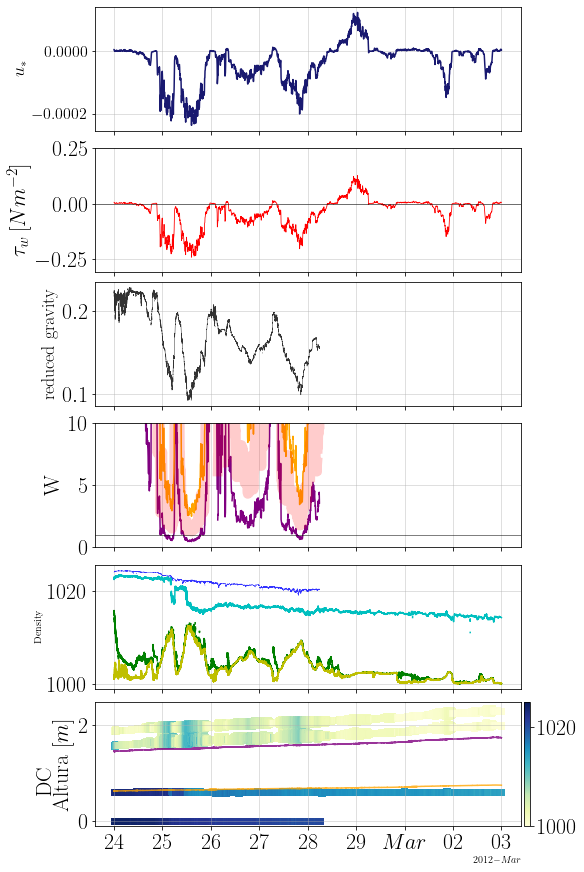

In [45]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6) = plt.subplots(nrows=6, figsize=(8, 12), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)

#Grafico de velocidad del agua 

ax1.set_title("")

ax1.plot(u_ast2.time, u_ast2.values, c='midnightblue')
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_ylabel("$u_*$", fontsize=18)
ax1.set_xlabel("")



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)

ax3.plot(dc.time, dc.sel(variables='Density', sensor=1), c='b', alpha=0.8, linewidth=0.5)

dc.sel(variables='Density', sensor=2).plot(ax=ax3, c='c')
dc.sel(variables='Density', sensor=3).plot(ax=ax3, c='g')
dc.sel(variables='Density', sensor=4).plot(ax=ax3, c='y')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.set_title("")
ax3.set_ylabel("Density")
ax3.set_xlabel("")

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)

ax4.plot(g_red.time, g_red, c='k', alpha=0.8, linewidth=0.5)

ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.set_title("")
ax4.set_xlabel("")
ax4.set_ylabel(r"reduced gravity ",
          fontsize=18)
#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$\tau_w\,[Nm^{-2}]$ ",
          fontsize=22)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.31, 0.25)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"W",
          fontsize=22)
Wu.plot(ax=ax5, c='purple')
Wd.plot(ax=ax5, c='orange')
Wc.plot(ax=ax5, c='r', lw=10, alpha=0.2)
ax5.axhline(y=1, color='k', linewidth=0.5)
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)
ax5.set_title("")
ax5.set_ylabel("W")
ax5.set_xlabel("")
ax5.set_ylim(0, 10)
ax5.grid(alpha=0.5)
# Grafico densidades DC
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax6.set_ylabel(r"DC \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax6.plot(dc.time, 0.7*dc.sel(variables='Depth', sensor=1), c='purple', alpha=0.8)
ax6.plot(dc.time, 0.3*dc.sel(variables='Depth', sensor=1), c='orange', alpha=0.8)
scat = ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=1), c=dc.sel(variables='Density', sensor=1), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=2), c=dc.sel(variables='Density', sensor=2), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=3), c=dc.sel(variables='Density', sensor=3), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=4), c=dc.sel(variables='Density', sensor=4), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax6, pad=0.007)
cbar2.ax.tick_params(labelsize=22)
ax6.xaxis.set_tick_params(labelsize=22)
ax6.yaxis.set_tick_params(labelsize=22)
ax6.grid(alpha=0.5)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

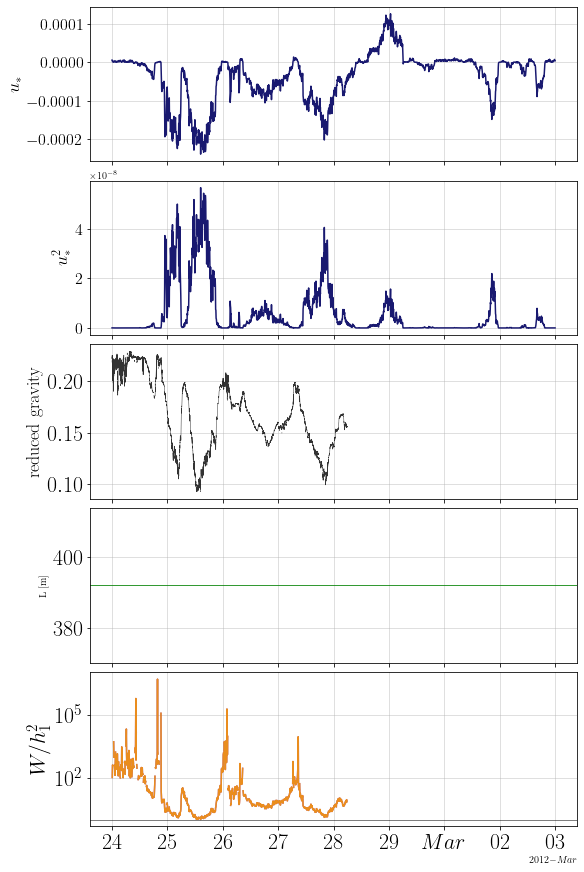

In [46]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax3, ax5) = plt.subplots(nrows=5, figsize=(8, 12), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)

#Grafico de velocidad del agua 

ax1.set_title("")

ax1.plot(u_ast2.time, u_ast2.values, c='midnightblue')
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_ylabel("$u_*$", fontsize=18)
ax1.set_xlabel("")



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)

ax3.axhline(y=L, color='g', linewidth=0.8)

ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.set_title("")
ax3.set_ylabel("L [m]")
ax3.set_xlabel("")

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)

ax4.plot(g_red.time, g_red, c='k', alpha=0.8, linewidth=0.5)

ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.set_title("")
ax4.set_xlabel("")
ax4.set_ylabel(r"reduced gravity ",
          fontsize=18)
#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_title("")

ax2.plot(u_ast2.time, u_ast2.values*u_ast2.values, c='midnightblue')
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.set_ylabel("$u_*^2$", fontsize=18)
ax2.set_xlabel("")

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"W",
          fontsize=22)
# ax5.plot(Wu.time, Wu/h1u**2, c="purple")
# ax5.plot(Wd.time, Wd/h1d**2, c="orange")
ax5.semilogy(Wu.time, Wu/h1u**2, c="purple", alpha=0.8)
ax5.semilogy(Wd.time, Wd/h1d**2, c="orange", alpha=0.8)
ax5.axhline(y=1, color='k', linewidth=0.5)
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)
ax5.set_title("")
ax5.set_ylabel("$W/h_1^2$",
          fontsize=22)
ax5.set_xlabel("")
# ax5.set_ylim(0, 10)
ax5.grid(alpha=0.5)


#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

### NM

In [47]:
min6_6 = pd.date_range(start=datetime(2012,2,24), end=datetime(2012,3,3), periods=None, freq='6min')
seg30 = pd.date_range(start=datetime(2012,2,24), end=datetime(2012,3,3), periods=None, freq='30S')

rho_water = nm.sel(variables='Density').mean('sensor')

g_red = (nm.sel(variables='Density', sensor=1, time=seg30)-nm.sel(variables='Density', sensor=3, time=seg30))*9.81/nm.sel(variables='Density', sensor=3, time=seg30)
rho_air = 1.2

Cd = 0.0014 #Tundisi2002
L = 392 #Obtenido de Google Earth

h1u = 0.3*dc.sel(variables='Depth', sensor=1) # 30% of total depth
h1d = 0.6*dc.sel(variables='Depth', sensor=1) # 60% of total depth
h1c = 0.5*dc.sel(variables='Depth', sensor=1) # 50% of total depth
u_ast2 = (wdf.rename_axis("time").to_xarray()/rho_water.sel(time=min6_6))

Wu = (g_red*h1u**2)/(L*abs(u_ast2))
Wd = (g_red*h1d**2)/(L*abs(u_ast2))
Wc = (g_red*h1c**2)/(L*abs(u_ast2))

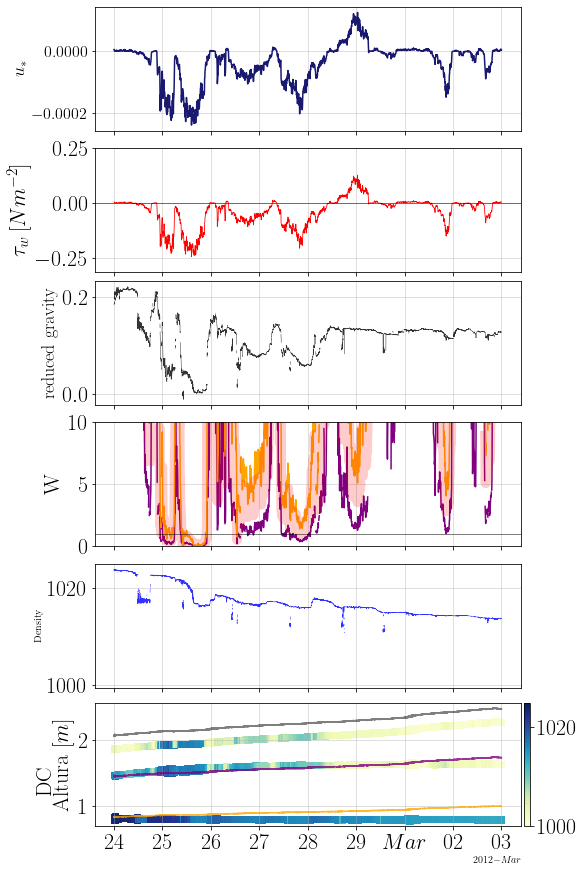

In [48]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6) = plt.subplots(nrows=6, figsize=(8, 12), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)

#Grafico de velocidad del agua 

ax1.set_title("")

ax1.plot(u_ast2.time, u_ast2.values, c='midnightblue')
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_ylabel("$u_*$", fontsize=18)
ax1.set_xlabel("")



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)

ax3.plot(nm.time, nm.sel(variables='Density', sensor=1), c='b', alpha=0.8, linewidth=0.5)

nm.sel(variables='Density', sensor=2).plot(ax=ax3, c='g')
nm.sel(variables='Density', sensor=3).plot(ax=ax3, c='y')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.set_title("")
ax3.set_ylabel("Density")
ax3.set_xlabel("")

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)

ax4.plot(g_red.time, g_red, c='k', alpha=0.8, linewidth=0.5)

ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.set_title("")
ax4.set_xlabel("")
ax4.set_ylabel(r"reduced gravity ",
          fontsize=18)
#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$\tau_w\,[Nm^{-2}]$ ",
          fontsize=22)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.31, 0.25)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"W",
          fontsize=22)
Wu.plot(ax=ax5, c='purple')
Wd.plot(ax=ax5, c='orange')
Wc.plot(ax=ax5, c='r', lw=10, alpha=0.2)
ax5.axhline(y=1, color='k', linewidth=0.5)
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)
ax5.set_title("")
ax5.set_ylabel("W")
ax5.set_xlabel("")
ax5.set_ylim(0, 10)
ax5.grid(alpha=0.5)
# Grafico densidades DC
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax6.set_ylabel(r"DC \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax6.plot(dc.time, dc.sel(variables='Depth', sensor=1), c='k', alpha=0.5)
ax6.plot(dc.time, 0.7*dc.sel(variables='Depth', sensor=1), c='purple', alpha=0.8)
ax6.plot(dc.time, 0.4*dc.sel(variables='Depth', sensor=1), c='orange', alpha=0.8)
scat = ax6.scatter(nm.time.values, nm.sel(variables='Depth2', sensor=1), c=nm.sel(variables='Density', sensor=1), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(nm.time.values, nm.sel(variables='Depth2', sensor=2), c=nm.sel(variables='Density', sensor=2), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(nm.time.values, nm.sel(variables='Depth2', sensor=3), c=nm.sel(variables='Density', sensor=3), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax6, pad=0.007)
cbar2.ax.tick_params(labelsize=22)
ax6.xaxis.set_tick_params(labelsize=22)
ax6.yaxis.set_tick_params(labelsize=22)
ax6.grid(alpha=0.5)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

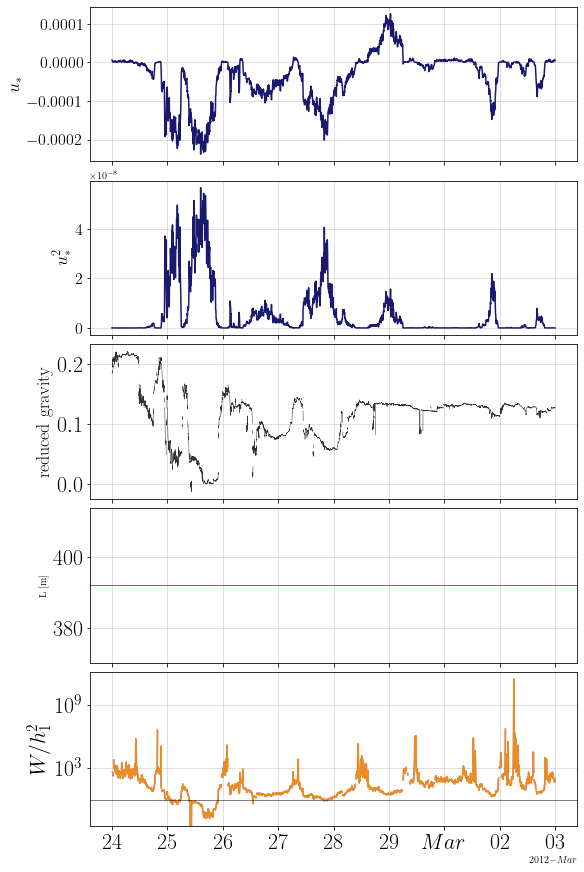

In [49]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax3, ax5) = plt.subplots(nrows=5, figsize=(8, 12), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)

#Grafico de velocidad del agua 

ax1.set_title("")

ax1.plot(u_ast2.time, u_ast2.values, c='midnightblue')
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_ylabel("$u_*$", fontsize=18)
ax1.set_xlabel("")



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)

ax3.axhline(y=L, color='g', linewidth=0.8)

ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.set_title("")
ax3.set_ylabel("L [m]")
ax3.set_xlabel("")

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)

ax4.plot(g_red.time, g_red, c='k', alpha=0.8, linewidth=0.5)

ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.set_title("")
ax4.set_xlabel("")
ax4.set_ylabel(r"reduced gravity ",
          fontsize=18)
#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_title("")

ax2.plot(u_ast2.time, u_ast2.values*u_ast2.values, c='midnightblue')
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.set_ylabel("$u_*^2$", fontsize=18)
ax2.set_xlabel("")

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"W",
          fontsize=22)
# ax5.plot(Wu.time, Wu/h1u**2, c="purple")
# ax5.plot(Wd.time, Wd/h1d**2, c="orange")
ax5.semilogy(Wu.time, Wu/h1u**2, c="purple", alpha=0.8)
ax5.semilogy(Wd.time, Wd/h1d**2, c="orange", alpha=0.8)
ax5.axhline(y=1, color='k', linewidth=0.5)
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)
ax5.set_title("")
ax5.set_ylabel("$W/h_1^2$",
          fontsize=22)
ax5.set_xlabel("")
# ax5.set_ylim(0, 10)
ax5.grid(alpha=0.5)


#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

### ML

In [50]:
min6_6 = pd.date_range(start=datetime(2012,2,24), end=datetime(2012,3,3), periods=None, freq='6min')
seg30 = pd.date_range(start=datetime(2012,2,24), end=datetime(2012,3,3), periods=None, freq='30S')

rho_water = ml.sel(variables='Density').mean('sensor')

g_red = (ml.sel(variables='Density', sensor=1, time=seg30)-ml.sel(variables='Density', sensor=2, time=seg30))*9.81/ml.sel(variables='Density', sensor=2, time=seg30)
rho_air = 1.2

Cd = 0.0014 #Tundisi2002
L = 392 #Obtenido de Google Earth

h1u = 0.3*dc.sel(variables='Depth', sensor=1) # 30% of total depth
h1d = 0.6*dc.sel(variables='Depth', sensor=1) # 60% of total depth
h1c = 0.5*dc.sel(variables='Depth', sensor=1) # 50% of total depth
u_ast2 = (wdf.rename_axis("time").to_xarray()/rho_water.sel(time=min6_6))

Wu = (g_red*h1u**2)/(L*abs(u_ast2))
Wd = (g_red*h1d**2)/(L*abs(u_ast2))
Wc = (g_red*h1c**2)/(L*abs(u_ast2))

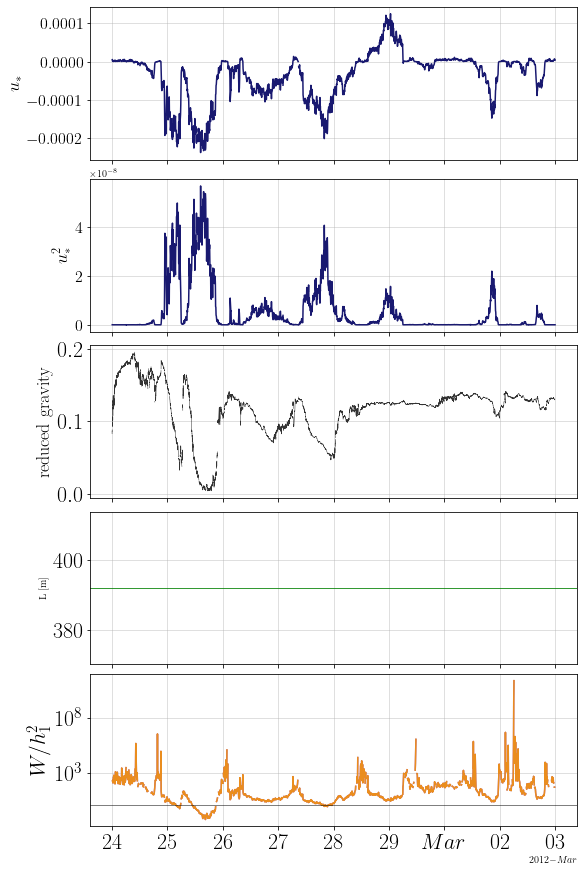

In [51]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax3, ax5) = plt.subplots(nrows=5, figsize=(8, 12), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)

#Grafico de velocidad del agua 

ax1.set_title("")

ax1.plot(u_ast2.time, u_ast2.values, c='midnightblue')
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_ylabel("$u_*$", fontsize=18)
ax1.set_xlabel("")



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)

ax3.axhline(y=L, color='g', linewidth=0.8)

ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.set_title("")
ax3.set_ylabel("L [m]")
ax3.set_xlabel("")

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)

ax4.plot(g_red.time, g_red, c='k', alpha=0.8, linewidth=0.5)

ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.set_title("")
ax4.set_xlabel("")
ax4.set_ylabel(r"reduced gravity ",
          fontsize=18)
#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_title("")

ax2.plot(u_ast2.time, u_ast2.values*u_ast2.values, c='midnightblue')
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.set_ylabel("$u_*^2$", fontsize=18)
ax2.set_xlabel("")

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"W",
          fontsize=22)
# ax5.plot(Wu.time, Wu/h1u**2, c="purple")
# ax5.plot(Wd.time, Wd/h1d**2, c="orange")
ax5.semilogy(Wu.time, Wu/h1u**2, c="purple", alpha=0.8)
ax5.semilogy(Wd.time, Wd/h1d**2, c="orange", alpha=0.8)
ax5.axhline(y=1, color='k', linewidth=0.5)
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)
ax5.set_title("")
ax5.set_ylabel("$W/h_1^2$",
          fontsize=22)
ax5.set_xlabel("")
# ax5.set_ylim(0, 10)
ax5.grid(alpha=0.5)


#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

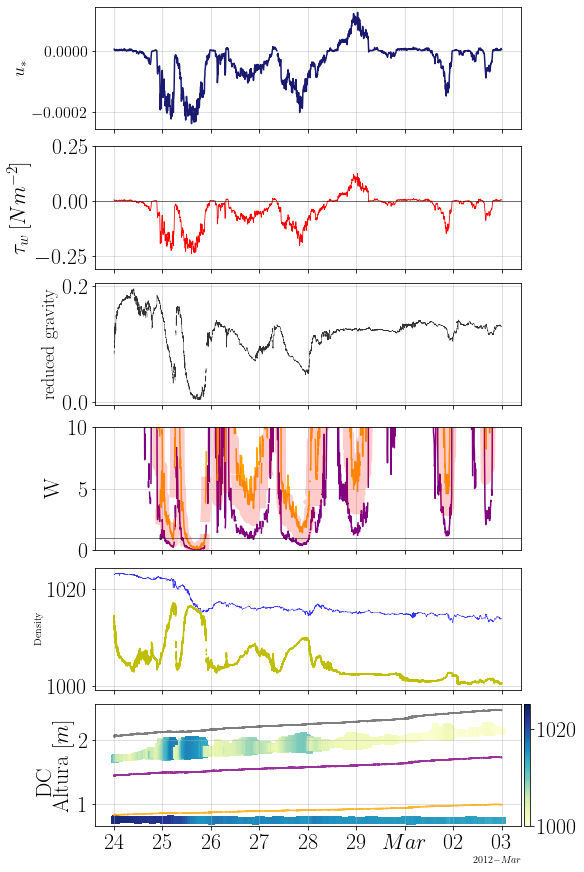

In [52]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6) = plt.subplots(nrows=6, figsize=(8, 12), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)

#Grafico de velocidad del agua 

ax1.set_title("")

ax1.plot(u_ast2.time, u_ast2.values, c='midnightblue')
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_ylabel("$u_*$", fontsize=18)
ax1.set_xlabel("")



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)

ax3.plot(ml.time, ml.sel(variables='Density', sensor=1), c='b', alpha=0.8, linewidth=0.5)

ml.sel(variables='Density', sensor=2).plot(ax=ax3, c='y')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.set_title("")
ax3.set_ylabel("Density")
ax3.set_xlabel("")

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)

ax4.plot(g_red.time, g_red, c='k', alpha=0.8, linewidth=0.5)

ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.set_title("")
ax4.set_xlabel("")
ax4.set_ylabel(r"reduced gravity ",
          fontsize=18)
#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$\tau_w\,[Nm^{-2}]$ ",
          fontsize=22)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.31, 0.25)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"W",
          fontsize=22)
Wu.plot(ax=ax5, c='purple')
Wd.plot(ax=ax5, c='orange')
Wc.plot(ax=ax5, c='r', lw=10, alpha=0.2)
ax5.axhline(y=1, color='k', linewidth=0.5)
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)
ax5.set_title("")
ax5.set_ylabel("W")
ax5.set_xlabel("")
ax5.set_ylim(0, 10)
ax5.grid(alpha=0.5)
# Grafico densidades DC
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax6.set_ylabel(r"DC \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax6.plot(dc.time, dc.sel(variables='Depth', sensor=1), c='k', alpha=0.5)
ax6.plot(dc.time, 0.7*dc.sel(variables='Depth', sensor=1), c='purple', alpha=0.8)
ax6.plot(dc.time, 0.4*dc.sel(variables='Depth', sensor=1), c='orange', alpha=0.8)
scat = ax6.scatter(ml.time.values, ml.sel(variables='Depth2', sensor=1), c=ml.sel(variables='Density', sensor=1), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(ml.time.values, ml.sel(variables='Depth2', sensor=2), c=ml.sel(variables='Density', sensor=2), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)

cbar2 = fig.colorbar(scat, ax=ax6, pad=0.007)
cbar2.ax.tick_params(labelsize=22)
ax6.xaxis.set_tick_params(labelsize=22)
ax6.yaxis.set_tick_params(labelsize=22)
ax6.grid(alpha=0.5)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

### Stevens and Imberger's method (1997) 

A crucial point when considering the usefulness of W and L, is that they are steady-state parameters. As the response is characterized by an internal standing wave of the gravest horizontal mode, the long-wave speed

\begin{equation}
c_l=\left(\frac{\epsilon gh_1 h_2}{h_1 + h_2 }\right)^{1/2}
\end{equation}


limits the rapidity of the tilting. Spigel & Imberger (1980) showed that, after commencement of the stress, it takes $1/4$ of the internal wave period

\begin{equation}
T_1 = 2L/c_l
\end{equation}

for the condition identified by W to occur.


2.3. Unsteadiness 

With more than one vertical wave mode the time-scales for maximum shear and tilt (i.e. $\frac{1}{4}T_1$ and $\frac{1}{2}T_1$ as identified by Spigel & Imberger 1980) are replaced by $T_i$ where the index represents the ith vertical mode. The appropriate non-dimensional ratio delineating whether the wind duration is of sufficient duration to allow tilting due to the ith mode to fully develop is 

\begin{equation}
\frac{4T_w}{T_i}
\end{equation}

where $T_w$, is the wind duration. A practical consideration related to this growth timescale is that a $u_*$ time-series should first be low-pass filtered with a filter time constant $~\frac{1}{4}T_1$ before a time-series of W or $L_N$, is calculated (Stevens et al. 1996).

** As h1 and h2 are changing, to find T1 I averaged all T1 calculated for each time-step. **


In [31]:
h2 = 0.7*dc.sel(variables='Depth', sensor=1) # 70% of total depth
cl = (g_red*h1u*h2/(h1u+h2))**0.5
T1 = 2*L/cl
T1.mean()//4
## I'm going to approximate T/4 to 12 minutes
T4 = 12 #min

In [32]:
## Low-pass filter functions
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [33]:
# Filter requirements.
order = 6
cutoff = (T1.mean()//2)**(-1)  # desired cutoff frequency of the filter, Hz

# Filtrado de datos
u_star_lpf = butter_lowpass_filter(u_ast2.values, cutoff, fs=1/360, order=6)

Text(0.5, 0, '')

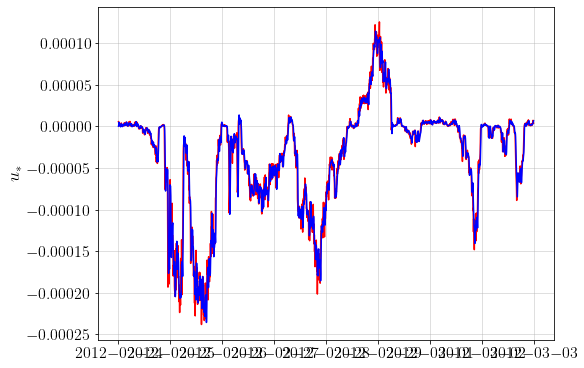

In [34]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1) = plt.subplots(nrows=1, figsize=(8, 5), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)

#Grafico de velocidad del agua 

ax1.set_title("")
ax1.plot(u_ast2.time, u_ast2.values, c="r")
ax1.plot(u_ast2.time, u_star_lpf, c="b")


ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_ylabel("$u_*$", fontsize=18)
ax1.set_xlabel("")


In [35]:
## time-dynamic back-looking averaging window

dt = min6_6 - timedelta(minutes=12)
u_star = pd.DataFrame(data={'ustar': u_star_lpf}, index = dt)


ValueError: Shape of passed values is (1919, 1), indices imply (1921, 1)

In [ ]:
min6_6 = pd.date_range(start=datetime(2012,2,11), end=datetime(2012,2,22), periods=None, freq='6min')

rho_water = dc.sel(variables='Density').mean('sensor')

g_red = (dc.sel(variables='Density', sensor=1)-dc.sel(variables='Density', sensor=4))*9.81/dc.sel(variables='Density', sensor=4)
rho_air = 1.2

Cd = 0.0014 #Tundisi2002
L = 392 #Obtenido de Google Earth

h1u = 0.3*dc.sel(variables='Depth', sensor=1) # 30% of total depth
h1d = 0.7*dc.sel(variables='Depth', sensor=1) # 70% of total depth
h1c = 0.5*dc.sel(variables='Depth', sensor=1) # 50% of total depth
u_star2 = u_star.rename_axis("time").to_xarray()

Wu = (g_red*h1u**2)/(L*abs(u_star2))
Wd = (g_red*h1d**2)/(L*abs(u_star2))
Wc = (g_red*h1c**2)/(L*abs(u_star2))

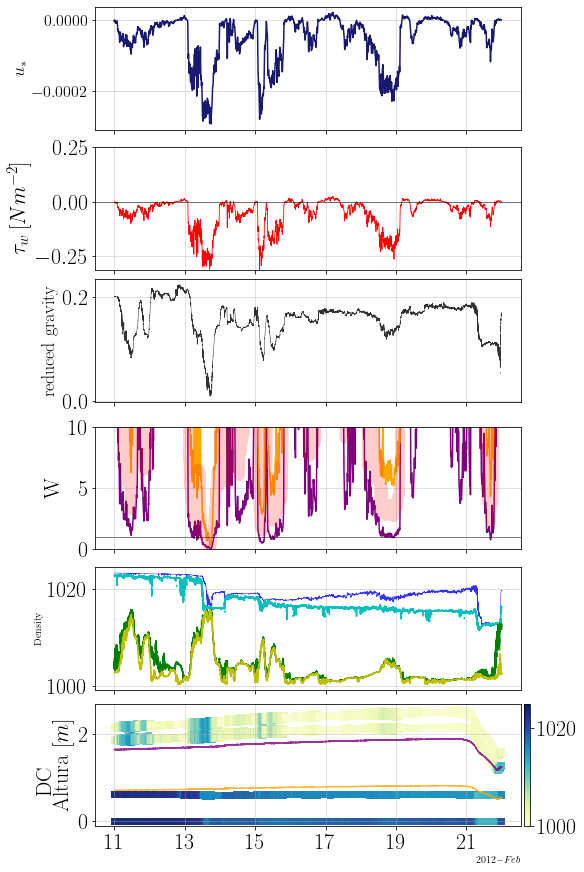

In [ ]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6) = plt.subplots(nrows=6, figsize=(8, 12), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)

#Grafico de velocidad del agua 

ax1.set_title("")

ax1.plot(u_star2.time, u_star2.ustar, c='midnightblue')
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_ylabel("$u_*$", fontsize=18)
ax1.set_xlabel("")



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)

ax3.plot(dc.time, dc.sel(variables='Density', sensor=1), c='b', alpha=0.8, linewidth=0.5)

dc.sel(variables='Density', sensor=2).plot(ax=ax3, c='c')
dc.sel(variables='Density', sensor=3).plot(ax=ax3, c='g')
dc.sel(variables='Density', sensor=4).plot(ax=ax3, c='y')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.set_title("")
ax3.set_ylabel("Density")
ax3.set_xlabel("")

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)

ax4.plot(g_red.time, g_red, c='k', alpha=0.8, linewidth=0.5)

ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.set_title("")
ax4.set_xlabel("")
ax4.set_ylabel(r"reduced gravity ",
          fontsize=18)
#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$\tau_w\,[Nm^{-2}]$ ",
          fontsize=22)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.31, 0.25)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"W",
          fontsize=22)
ax5.plot(Wu.time, Wu.ustar, c='purple')
ax5.plot(Wd.time, Wd.ustar, c='orange')
ax5.plot(Wc.time, Wc.ustar, c='r', lw=10, alpha=0.2)
# ax5.plot(ml.time, ml.sel(variables='Density', sensor=1), c='b', alpha=0.9, linewidth=0.5)

ax5.axhline(y=1, color='k', linewidth=0.5)
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)
ax5.set_title("")
ax5.set_ylabel("W")
ax5.set_xlabel("")
ax5.set_ylim(0, 10)
ax5.grid(alpha=0.5)
# Grafico densidades DC
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax6.set_ylabel(r"DC \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax6.plot(dc.time, 0.7*dc.sel(variables='Depth', sensor=1), c='purple', alpha=0.8)
ax6.plot(dc.time, 0.3*dc.sel(variables='Depth', sensor=1), c='orange', alpha=0.8)
scat = ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=1), c=dc.sel(variables='Density', sensor=1), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=2), c=dc.sel(variables='Density', sensor=2), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=3), c=dc.sel(variables='Density', sensor=3), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax6.scatter(dc.time.values, dc.sel(variables='Depth2', sensor=4), c=dc.sel(variables='Density', sensor=4), marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax6, pad=0.007)
cbar2.ax.tick_params(labelsize=22)
ax6.xaxis.set_tick_params(labelsize=22)
ax6.yaxis.set_tick_params(labelsize=22)
ax6.grid(alpha=0.5)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 